In [1]:
import os
import numpy as np
import pandas as pd
from Bio import SeqIO
from Bio.Seq import Seq
from Bio import motifs
import matplotlib.pyplot as plt

Open a text file containing the chromosomal positions of nucleosome centers in mouse ESCs

In [2]:
data_mus = pd.read_fwf("D:\Winter 2021\BIMM 143\Mus_ncp.txt", widths = [2,12], names = ['chr', 'ncp'])
print(data_mus.head(3))
print(data_mus.tail(3))

   chr      ncp
0    1  3000002
1    1  3000175
2    1  3000364
          chr      ncp
10677013   21  2902023
10677014   21  2902255
10677015   21  2902427


Create a dictionary for accessing mouse genome data by chromosome.
Keys are chromosome numbers while values are file paths to the fasta file.

In [3]:
Mus_genome = {}

for i in range(21):
    filename = ''.join(["D:\Winter 2021\BIMM 143\mm10_", str(i+1), ".txt"])
    Mus_genome[i] = filename

Retrieving the nucleotide sequences flanking the nucleosome center position (the 'nucleosomecore') and writing them to an output file.
Here the flank width is 200 nucleotides.

Nucleosome center positions are screened and ones too close to the edge (or in the case of chromosome 1, for some reason exceeding the chromosome length, probably due to the use of different assemblies) are dropped.

The chromosome sequences are opened one at a time as seq files to conserve memory.
The mouse has 19 pairs of autosomes, so there will be a total of 21 output files, one for each chromosome (19+X+Y).

Intermediate data are printed out periodically to check for bugs and track code progress.

In [7]:
baselen = 200

for i in range(21):
    chrom = data_mus[data_mus['chr']==i+1].copy()
    print(chrom.head(1))
    print(chrom.tail(1))
    
    with open(Mus_genome[i]) as file:
        chrseq = SeqIO.read(file, "fasta")
        print(chrseq)
        
        chrom.drop(chrom[chrom['ncp']>(len(chrseq)-baselen)].index, inplace=True)
        chrom.drop(chrom[chrom['ncp']<baselen+1].index, inplace=True)
    
        chrom['nucleosomecore'] = chrom.apply(lambda row : chrseq.seq[row['ncp']-baselen-1:row['ncp']+baselen], axis = 1)
    
        print(chrom.head(1))
        print(chrom.tail(1))
        
    outfile = ''.join(["D:\Winter 2021\BIMM 143\Mus_nucleosomecore_", str(i+1), ".txt"])
    
    with open(outfile, "w") as file:
        chrom.to_csv(file, header=False, index=False)
        print('saved', str(i+1))

   chr      ncp
0    1  3000002
        chr        ncp
811345    1  197195276
ID: NC_000067.7
Name: NC_000067.7
Description: NC_000067.7 Mus musculus strain C57BL/6J chromosome 1, GRCm39
Number of features: 0
Seq('NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...NNN', SingleLetterAlphabet())
   chr      ncp                                     nucleosomecore
0    1  3000002  (N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ...
        chr        ncp                                     nucleosomecore
802521    1  195153938  (N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ...
saved 1
        chr      ncp
811346    2  3000125
         chr        ncp
1568228    2  181747814
ID: NC_000068.8
Name: NC_000068.8
Description: NC_000068.8 Mus musculus strain C57BL/6J chromosome 2, GRCm39
Number of features: 0
Seq('NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...NNN', SingleLetterAlphabet())
        chr      ncp                                     nucleosomecore
811346    2  3000125  (N

         chr      ncp                                     nucleosomecore
7757501   14  3000066  (N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ...
         chr        ncp                                     nucleosomecore
8261277   14  125139454  (N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ...
saved 14
         chr      ncp
8261499   15  3000003
         chr        ncp
8687485   15  103494810
ID: NC_000081.7
Name: NC_000081.7
Description: NC_000081.7 Mus musculus strain C57BL/6J chromosome 15, GRCm39
Number of features: 0
Seq('NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...NNN', SingleLetterAlphabet())
         chr      ncp                                     nucleosomecore
8261499   15  3000003  (N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ...
         chr        ncp                                     nucleosomecore
8687485   15  103494810  (C, A, C, T, C, C, C, T, T, A, A, T, C, T, G, ...
saved 15
         chr      ncp
8687486   16  3000027
         chr       ncp
9092367

Nucleotide dimer occurrences are tallied in a 400x16 data frame; each column represents a type of dimer while each row represents a dinucleotide frame along the DNA sequence surrounding the nucleosome.

The dinucleotide frame is looped over the 401bp sequence for each nucleosomecore; this results in a total of 400 frames, and the dataframe row index indicates the position of the first nucleotide in the nucleosomecore.

This process is done by reading the 21 files created earlier in chunks.
Sequences are screened and the ones containing Ns or have lengths shorter than 401 nucleotides are dropped.
Each chunk produces a 400x16 'chunk dimer dataframe'; the 'chunk dimer dataframe's are summed together, cell to cell, to produce a 400x16 'toal dimer dataframe'.

Intermediate data are printed out periodically to check for bugs and track code progress.

In [13]:
rows_read = 0
total_dimer_df = pd.DataFrame(np.zeros([400,16]), columns=['TG', 'TT', 'AT', 'TA', 'AA', 'GG', 'AG', 'CT', 'CA', 'TC', 'CC', 'AC', 'GC', 'GA', 'GT', 'CG'])
print(total_dimer_df.head(2))
print(total_dimer_df.tail(2))

for i in range(21):
    print('opening chromosome', str(i+1))
    csvname = ''.join(["D:\Winter 2021\BIMM 143\Mus_nucleosomecore_", str(i+1), ".txt"])
    chunks = pd.read_csv(csvname, chunksize = 10000, index_col=None, names=['chr', 'ncp', 'nucleosomecore'])

    for chunk in chunks:
        
        rows_read += len(chunk.index)
        print('rows read:', str(rows_read))
    
        length_check = chunk[chunk['nucleosomecore'].apply(lambda x: len(x) != baselen*2+1)].index
        N_check = chunk[chunk['nucleosomecore'].apply(lambda x: 'N' in x)].index
        droplist = list(set(length_check) | set(N_check))
        chunk.drop(droplist, inplace=True)
        print('rows discarded:', str(len(droplist)))
        
        chunk_dimer_df = pd.DataFrame(columns=['TG', 'TT', 'AT', 'TA', 'AA', 'GG', 'AG', 'CT', 'CA', 'TC', 'CC', 'AC', 'GC', 'GA', 'GT', 'CG'])
        print('empty chunk dimer')
        print(chunk_dimer_df.head(2))
        print(chunk_dimer_df.tail(2))
        
        for i in range(baselen*2):
            site_dict = chunk['nucleosomecore'].apply(lambda x: str(x[i:i+2])).value_counts().to_dict()
            chunk_dimer_df = chunk_dimer_df.append(site_dict, ignore_index = True)
    
        chunk_dimer_df.fillna(0, inplace=True)
        print('filled chunk dimer')
        print(chunk_dimer_df.head(2))
        print(chunk_dimer_df.tail(2))
        
        total_dimer_df = total_dimer_df + chunk_dimer_df
        print('total dimer count')
        print(total_dimer_df.head(2))
        print(total_dimer_df.tail(2))

    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

    CG  
0  0.0  
1  0.0  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
399  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

      GT   CG  
398  0.0  0.0  
399  0.0  0.0  
opening chromosome 1
rows read: 10000
rows discarded: 198
empty chunk dimer
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
filled chunk dimer
    TG   TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  748  969  759  713  1040  437  642  722  682  608  449  502  341  587  53

filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  727  934  757  627  919  452  762  757  747  624  498  545  394  629  550   
1  746  965  722  645  924  501  748  689  777  642  510  528  380  614  524   

   CG  
0  78  
1  85  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  790  950  747  675  934  478  735  715  700  647  487  532  403  577   
399  794  914  720  631  904  526  690  718  766  619  521  572  389  619   

      GT  CG  
398  546  84  
399  553  64  
total dimer count
       TG      TT      AT      TA      AA      GG      AG      CT      CA  \
0  4373.0  5862.0  4629.0  4061.0  5940.0  2831.0  4272.0  4347.0  4333.0   
1  4348.0  5818.0  4681.0  4023.0  5868.0  2947.0  4324.0  4229.0  4424.0   

       TC      CC      AC      GC      GA      GT     CG  
0  3736.0  2828.0  3154.0  2171.0  3687.0  3165.0  413.0  
1  3814.0  2831.0  3148.0  2221.0  3666.0  3055.0  405.0  
         TG 

filled chunk dimer
    TG    TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
0  672  1039  961  779  1039  408  599  665  760  598  414  493  318  639   
1  712  1121  944  826  1107  368  658  677  686  561  407  508  283  568   

    GT  CG  
0  555  61  
1  521  53  
      TG    TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  742  1091  916  809  1095  428  683  648  666  607  397  462  298  588   
399  691  1071  961  799  1032  449  641  653  676  603  384  524  318  637   

      GT  CG  
398  509  61  
399  510  51  
total dimer count
       TG       TT      AT      TA       AA      GG      AG      CT      CA  \
0  7761.0  10784.0  8839.0  7763.0  11167.0  5115.0  7673.0  7786.0  7918.0   
1  7993.0  10816.0  8876.0  7645.0  11135.0  5151.0  7892.0  7648.0  8055.0   

       TC      CC      AC      GC      GA      GT     CG  
0  6822.0  5090.0  5707.0  3926.0  6855.0  5871.0  723.0  
1  6826.0  5117.0  5800.0  3893.0  6708.0  5520.0  72

filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  748  828  666  623  729  628  729  810  793  616  582  523  468  583  565   
1  805  834  635  579  771  613  779  792  764  651  528  543  442  606  553   

    CG  
0  109  
1  105  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  829  823  661  539  738  612  764  791  725  626  564  533  463  610   
399  845  859  609  552  764  606  731  737  801  639  543  508  476  663   

      GT   CG  
398  620  102  
399  562  105  
total dimer count
        TG       TT       AT       TA       AA      GG       AG       CT  \
0  11477.0  15206.0  12465.0  10939.0  15500.0  7935.0  11263.0  11460.0   
1  11772.0  15328.0  12462.0  10731.0  15491.0  7878.0  11607.0  11308.0   

        CA      TC      CC      AC      GC      GA      GT      CG  
0  11775.0  9902.0  7731.0  8344.0  6045.0  9883.0  8662.0  1213.0  
1  11870.0  9962.0  7698.0  8537.0  6040.0  9835

filled chunk dimer
    TG   TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  741  944  732  655  1049  473  736  695  760  602  520  543  371  570  527   
1  700  920  770  669  1026  498  735  727  755  609  476  503  396  618  520   

   CG  
0  82  
1  78  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  706  923  770  631  994  461  732  726  778  605  536  535  376  617   
399  706  941  775  694  987  462  716  700  818  598  468  542  394  606   

      GT  CG  
398  520  90  
399  527  66  
total dimer count
        TG       TT       AT       TA       AA       GG       AG       CT  \
0  15160.0  20209.0  16486.0  14456.0  20596.0  10261.0  14764.0  15090.0   
1  15415.0  20338.0  16640.0  14255.0  20542.0  10265.0  15069.0  14776.0   

        CA       TC       CC       AC      GC       GA       GT      CG  
0  15364.0  12906.0  10058.0  10947.0  7792.0  12902.0  11246.0  1563.0  
1  15460.0  13023.0  10001.0  11067.0 

filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  756  885  736  630  878  528  758  736  747  658  504  512  393  638  542   
1  723  947  740  631  888  516  769  730  736  598  514  496  424  622  579   

   CG  
0  99  
1  87  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  757  878  740  586  925  495  769  769  762  617  526  545  412  643   
399  752  896  749  636  930  538  711  720  763  602  540  526  450  605   

      GT  CG  
398  499  77  
399  505  77  
total dimer count
        TG       TT       AT       TA       AA       GG       AG       CT  \
0  18859.0  24833.0  20157.0  17656.0  25282.0  12833.0  18376.0  18731.0   
1  19001.0  25041.0  20358.0  17536.0  25238.0  12807.0  18838.0  18529.0   

        CA       TC       CC       AC      GC       GA       GT      CG  
0  19128.0  16074.0  12546.0  13588.0  9848.0  16008.0  13899.0  1982.0  
1  19162.0  16042.0  12506.0  13640.0  97

filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  765  829  625  506  802  606  736  784  741  631  622  544  497  642  557   
1  765  853  614  535  759  613  773  801  741  642  618  545  456  615  536   

    CG  
0  113  
1  134  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  774  801  600  521  779  620  779  766  770  587  661  586  489  628   
399  760  795  605  509  747  651  804  773  795  622  632  542  482  630   

      GT   CG  
398  519  120  
399  530  123  
total dimer count
        TG       TT       AT       TA       AA       GG       AG       CT  \
0  22580.0  29374.0  23998.0  20940.0  30030.0  15364.0  21993.0  22379.0   
1  22723.0  29661.0  24086.0  20791.0  29941.0  15375.0  22459.0  22137.0   

        CA       TC       CC       AC       GC       GA       GT      CG  
0  22753.0  19155.0  15060.0  16219.0  11907.0  19137.0  16532.0  2379.0  
1  22884.0  19108.0  15007.0  163

filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  794  768  598  474  698  660  801  809  779  653  612  561  486  643  566   
1  825  793  572  512  722  642  810  802  781  611  628  490  500  635  576   

    CG  
0   98  
1  101  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  813  789  607  472  692  642  765  798  748  691  612  514  496  672   
399  819  779  596  528  717  620  749  786  803  631  617  522  517  661   

      GT   CG  
398  563  126  
399  548  107  
total dimer count
        TG       TT       AT       TA       AA       GG       AG       CT  \
0  26314.0  33818.0  27568.0  23938.0  34445.0  18047.0  25704.0  26131.0   
1  26468.0  34058.0  27638.0  23919.0  34393.0  18076.0  26257.0  25861.0   

        CA       TC       CC       AC       GC       GA       GT      CG  
0  26535.0  22308.0  17706.0  18956.0  14020.0  22258.0  19186.0  2778.0  
1  26708.0  22258.0  17700.0  188

filled chunk dimer
    TG    TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
0  725   980  916  749  1040  402  710  716  715  599  419  511  320  621   
1  765  1058  876  706  1013  410  692  689  703  600  416  544  339  630   

    GT  CG  
0  517  60  
1  518  41  
      TG    TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  708  1017  881  737  999  424  690  726  730  621  416  523  321  634   
399  767   993  917  749  974  419  684  705  690  655  436  525  327  592   

      GT  CG  
398  540  33  
399  517  50  
total dimer count
        TG       TT       AT       TA       AA       GG       AG       CT  \
0  30089.0  38492.0  31397.0  27178.0  38965.0  20678.0  29365.0  29762.0   
1  30295.0  38724.0  31372.0  27261.0  38940.0  20667.0  29879.0  29505.0   

        CA       TC       CC       AC       GC       GA       GT      CG  
0  30258.0  25470.0  20144.0  21505.0  16011.0  25382.0  21887.0  3129.0  
1  30311.0  25258.0  20270.0  

filled chunk dimer
    TG    TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
0  717   982  871  709   959  440  708  700  743  621  452  531  338  647   
1  702  1001  818  768  1027  474  696  700  766  613  437  517  329  578   

    GT  CG  
0  531  51  
1  535  39  
      TG    TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  673   992  877  701  1012  457  683  723  739  608  471  553  325  635   
399  684  1029  827  768  1037  438  702  678  776  618  467  521  337  613   

      GT  CG  
398  507  44  
399  469  36  
total dimer count
        TG       TT       AT       TA       AA       GG       AG       CT  \
0  33605.0  43797.0  35666.0  30762.0  43947.0  22835.0  32820.0  33316.0   
1  33979.0  43904.0  35543.0  31007.0  43962.0  22871.0  33360.0  32990.0   

        CA       TC       CC       AC       GC       GA       GT      CG  
0  33830.0  28595.0  22387.0  24123.0  17685.0  28411.0  24516.0  3417.0  
1  33924.0  28405.0  22599.

filled chunk dimer
    TG   TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  701  871  816  732   988  481  737  705  738  642  473  551  395  602  524   
1  772  884  778  679  1032  490  684  749  791  581  463  566  368  618  487   

   CG  
0  44  
1  58  
      TG   TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  741  853  825  703  1011  449  711  693  771  596  504  565  364  621   
399  714  878  821  679   981  465  746  716  751  622  499  558  368  607   

      GT  CG  
398  522  71  
399  532  63  
total dimer count
        TG       TT       AT       TA       AA       GG       AG       CT  \
0  37395.0  48335.0  39564.0  34132.0  48430.0  25372.0  36440.0  36956.0   
1  37920.0  48366.0  39423.0  34256.0  48592.0  25394.0  36911.0  36586.0   

        CA       TC       CC       AC       GC       GA       GT      CG  
0  37592.0  31719.0  24860.0  26763.0  19669.0  31544.0  27234.0  3707.0  
1  37709.0  31547.0  25124.0  267

filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  777  838  593  549  782  588  748  805  740  648  649  497  501  589  578   
1  771  841  583  561  765  600  765  829  717  641  635  547  458  607  566   

    CG  
0  118  
1  114  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  820  824  574  558  806  608  787  807  756  630  581  516  477  576   
399  776  854  631  497  778  658  794  736  758  646  605  493  456  643   

      GT   CG  
398  568  112  
399  570  105  
total dimer count
        TG       TT       AT       TA       AA       GG       AG       CT  \
0  41274.0  52365.0  42771.0  36956.0  52550.0  28298.0  40230.0  40878.0   
1  41742.0  52537.0  42664.0  37052.0  52592.0  28362.0  40845.0  40519.0   

        CA       TC       CC       AC       GC       GA       GT      CG  
0  41410.0  34801.0  27777.0  29415.0  21997.0  34738.0  30025.0  4227.0  
1  41400.0  34708.0  28003.0  295

filled chunk dimer
    TG    TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
0  688  1048  930  773  1082  436  659  678  707  611  388  475  310  664   
1  646  1081  962  777  1084  455  672  645  669  649  421  508  310  561   

    GT  CG  
0  497  54  
1  511  49  
      TG    TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  733  1071  886  794  1078  429  689  671  712  603  417  487  299  570   
399  667  1061  943  845  1082  412  633  639  695  561  423  496  333  644   

      GT  CG  
398  506  55  
399  517  49  
total dimer count
        TG       TT       AT       TA       AA       GG       AG       CT  \
0  44784.0  57589.0  47218.0  40795.0  57814.0  30463.0  43598.0  44260.0   
1  45092.0  57798.0  47095.0  40873.0  57957.0  30481.0  44280.0  43908.0   

        CA       TC       CC       AC       GC       GA       GT      CG  
0  45012.0  37831.0  29899.0  31905.0  23681.0  37857.0  32509.0  4497.0  
1  44881.0  37813.0  30168.

filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  701  842  711  682  985  484  820  786  760  619  556  493  384  629  467   
1  703  844  793  659  973  504  747  697  743  600  529  543  420  633  529   

   CG  
0  81  
1  83  
      TG   TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  688  932  700  675  1041  507  775  731  723  576  494  562  400  591   
399  760  893  756  637   973  531  789  693  772  608  507  512  377  612   

      GT  CG  
398  535  70  
399  520  60  
total dimer count
        TG       TT       AT       TA       AA       GG       AG       CT  \
0  48487.0  61993.0  50708.0  43965.0  62404.0  33101.0  47449.0  48029.0   
1  48666.0  62189.0  50691.0  43981.0  62540.0  33122.0  48085.0  47648.0   

        CA       TC       CC       AC       GC       GA       GT      CG  
0  48807.0  40877.0  32585.0  34540.0  25784.0  41032.0  35042.0  4909.0  
1  48566.0  40936.0  32773.0  34892.

filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  758  814  615  539  839  608  792  717  765  667  536  552  449  634  581   
1  714  843  650  547  816  622  790  781  708  623  598  521  469  679  518   

    CG  
0  130  
1  117  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  768  798  609  572  816  600  737  794  757  629  644  517  432  676   
399  765  790  650  521  863  637  780  761  686  657  650  528  458  580   

      GT   CG  
398  532  115  
399  545  125  
total dimer count
        TG       TT       AT       TA       AA       GG       AG       CT  \
0  52203.0  66368.0  54123.0  46974.0  66919.0  35734.0  51189.0  51769.0   
1  52404.0  66504.0  54255.0  46995.0  66962.0  35770.0  51849.0  51419.0   

        CA       TC       CC       AC       GC       GA       GT      CG  
0  52590.0  44023.0  35197.0  37323.0  27929.0  44188.0  37736.0  5437.0  
1  52263.0  44093.0  35476.0  376

filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  764  815  694  530  835  545  769  781  792  600  575  565  450  644  528   
1  785  830  663  539  765  578  789  782  714  664  583  584  449  593  568   

    CG  
0  110  
1  111  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  748  887  651  585  793  579  750  782  757  654  586  531  443  637   
399  766  841  667  555  772  543  781  767  744  673  595  552  450  619   

      GT   CG  
398  515   99  
399  564  108  
total dimer count
        TG       TT       AT       TA       AA       GG       AG       CT  \
0  55995.0  70686.0  57585.0  49953.0  71406.0  38358.0  54966.0  55504.0   
1  56174.0  70831.0  57755.0  49924.0  71377.0  38486.0  55599.0  55105.0   

        CA       TC       CC       AC       GC       GA       GT      CG  
0  56388.0  47109.0  37979.0  40031.0  30063.0  47331.0  40445.0  5900.0  
1  56029.0  47291.0  38243.0  403

filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC  GC   GA   GT  \
0  149  199  156  148  220  101  164  140  139  126  105  102  82  128  111   
1  129  194  178  152  214  105  139  164  153  131   79  104  69  131  125   

   CG  
0  16  
1  19  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  153  205  163  122  210   81  146  170  148  123  106  117  102  125   
399  170  207  168  144  184  112  146  156  154  120  121  107   64  117   

      GT  CG  
398  103  12  
399   99  17  
total dimer count
        TG       TT       AT       TA       AA       GG       AG       CT  \
0  59347.0  74145.0  60344.0  52519.0  74758.0  40744.0  58191.0  58699.0   
1  59429.0  74334.0  60538.0  52337.0  74901.0  40757.0  58825.0  58255.0   

        CA       TC       CC       AC       GC       GA       GT      CG  
0  59583.0  49743.0  40288.0  42373.0  31955.0  49997.0  42783.0  6316.0  
1  59294.0  49871.0  40609.0  42593.0  314

filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  778  997  800  681  972  449  717  736  706  592  462  536  394  637  479   
1  764  987  804  624  941  486  731  685  753  637  481  520  344  628  550   

   CG  
0  64  
1  65  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  770  942  794  646  967  463  741  698  758  630  437  508  355  677   
399  728  952  797  679  972  507  771  702  690  619  468  508  364  673   

      GT  CG  
398  544  70  
399  500  70  
total dimer count
        TG       TT       AT       TA       AA       GG       AG       CT  \
0  63088.0  78695.0  64073.0  55685.0  79296.0  43213.0  61825.0  62396.0   
1  63097.0  78905.0  64170.0  55453.0  79510.0  43271.0  62505.0  61947.0   

        CA       TC       CC       AC       GC       GA       GT      CG  
0  63353.0  52811.0  42775.0  45078.0  34035.0  53230.0  45335.0  6682.0  
1  62973.0  53044.0  43143.0  45379.0  

filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  794  643  549  481  685  698  808  834  838  600  696  551  551  668  499   
1  743  670  529  471  732  700  871  802  803  641  678  540  575  621  509   

    CG  
0  105  
1  115  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  787  635  527  457  724  705  810  783  831  604  748  551  520  632   
399  760  625  523  483  749  706  806  797  801  641  705  566  540  612   

      GT   CG  
398  564  122  
399  566  120  
total dimer count
        TG       TT       AT       TA       AA       GG       AG       CT  \
0  66790.0  83256.0  67672.0  58751.0  83938.0  45849.0  65545.0  66172.0   
1  66854.0  83464.0  67777.0  58518.0  84142.0  45914.0  66282.0  65611.0   

        CA       TC       CC       AC       GC       GA       GT      CG  
0  67185.0  55869.0  45367.0  47755.0  36037.0  56382.0  47954.0  7041.0  
1  66615.0  56218.0  45804.0  480

filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  755  905  699  666  940  533  707  732  741  648  503  541  401  585  554   
1  744  904  751  624  936  530  695  778  716  618  517  550  392  619  544   

   CG  
0  90  
1  82  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  758  906  724  631  943  546  749  723  722  654  537  530  396  600   
399  728  930  736  607  948  555  700  746  758  604  525  512  431  590   

      GT  CG  
398  516  65  
399  542  88  
total dimer count
        TG       TT       AT       TA       AA       GG       AG       CT  \
0  70846.0  86944.0  70400.0  61203.0  87564.0  49141.0  69504.0  70247.0   
1  70857.0  87199.0  70613.0  60981.0  87853.0  49236.0  70129.0  69551.0   

        CA       TC       CC       AC       GC       GA       GT      CG  
0  71133.0  59004.0  48553.0  50463.0  38616.0  59493.0  50821.0  7631.0  
1  70474.0  59375.0  49060.0  50798.0  

filled chunk dimer
    TG    TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  757   982  797  699  964  449  725  691  737  566  506  520  387  631  530   
1  681  1008  769  691  997  436  702  715  711  620  492  563  394  631  529   

   CG  
0  59  
1  61  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  729  996  793  716  988  455  726  716  693  635  474  459  379  648   
399  743  991  802  715  975  469  722  707  713  581  453  546  385  611   

      GT  CG  
398  525  68  
399  513  74  
total dimer count
        TG       TT       AT       TA       AA       GG       AG       CT  \
0  74442.0  91992.0  74569.0  64913.0  92757.0  51400.0  73087.0  73725.0   
1  74401.0  92100.0  74748.0  64678.0  93074.0  51460.0  73638.0  72971.0   

        CA       TC       CC       AC       GC       GA       GT      CG  
0  74742.0  61981.0  50768.0  53016.0  40393.0  62530.0  53357.0  7891.0  
1  73986.0  62464.0  51389.0  53482.

filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  725  902  703  639  915  527  721  706  743  612  519  615  396  642  532   
1  723  964  765  614  900  540  741  781  736  542  532  533  412  574  550   

    CG  
0  103  
1   93  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  782  944  766  668  857  475  688  749  762  640  505  549  413  595   
399  756  974  696  630  912  505  753  745  759  620  502  521  389  602   

      GT   CG  
398  521   86  
399  535  101  
total dimer count
        TG       TT       AT       TA       AA       GG       AG       CT  \
0  78041.0  96753.0  78453.0  68295.0  97526.0  53850.0  76646.0  77309.0   
1  78133.0  96989.0  78670.0  68042.0  97840.0  53842.0  77259.0  76582.0   

        CA       TC       CC       AC       GC       GA       GT      CG  
0  78379.0  65073.0  53200.0  55745.0  42312.0  65660.0  56053.0  8268.0  
1  77635.0  65404.0  53889.0  560

filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  765  854  659  585  890  518  736  725  722  648  573  530  456  639  579   
1  744  865  664  581  837  531  767  761  767  627  571  568  465  591  553   

    CG  
0  121  
1  108  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  756  851  663  524  862  592  774  751  737  633  552  543  439  650   
399  736  865  607  629  874  557  759  740  744  588  553  533  475  658   

      GT   CG  
398  553  120  
399  552  130  
total dimer count
        TG        TT       AT       TA        AA       GG       AG       CT  \
0  81702.0  101585.0  82267.0  71623.0  102516.0  56266.0  80184.0  80745.0   
1  81849.0  101660.0  82517.0  71358.0  102607.0  56223.0  80941.0  80096.0   

        CA       TC       CC       AC       GC       GA       GT      CG  
0  82014.0  68071.0  55764.0  58390.0  44276.0  68726.0  58753.0  8681.0  
1  81411.0  68483.0  56316.

filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  721  945  744  628  942  520  769  707  720  561  507  573  375  651  549   
1  706  951  721  673  924  513  767  684  727  615  520  529  404  639  542   

   CG  
0  88  
1  85  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  716  974  766  598  934  487  751  716  707  589  516  562  426  623   
399  701  984  697  652  967  485  711  756  734  674  526  487  401  616   

      GT  CG  
398  555  80  
399  532  77  
total dimer count
        TG        TT       AT       TA        AA       GG       AG       CT  \
0  85294.0  106450.0  86070.0  74958.0  107342.0  58737.0  83830.0  84364.0   
1  85471.0  106541.0  86425.0  74782.0  107419.0  58704.0  84592.0  83676.0   

        CA       TC       CC       AC       GC       GA       GT      CG  
0  85620.0  71034.0  58222.0  61064.0  46188.0  71864.0  61423.0  9103.0  
1  85044.0  71513.0  58689.0  613

filled chunk dimer
    TG    TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
0  766  1052  881  773  1015  444  720  700  699  596  389  463  336  609   
1  731  1079  918  729  1015  444  639  652  684  599  399  524  340  652   

    GT  CG  
0  505  52  
1  546  49  
      TG    TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  738  1058  834  755   923  424  707  723  692  602  429  529  357  645   
399  746  1004  842  809  1001  448  686  700  748  590  423  486  327  620   

      GT  CG  
398  534  50  
399  524  46  
total dimer count
        TG        TT       AT       TA        AA       GG       AG       CT  \
0  89012.0  111101.0  89930.0  78385.0  112010.0  61294.0  87373.0  87985.0   
1  89055.0  111315.0  90423.0  78188.0  112152.0  61161.0  88184.0  87345.0   

        CA       TC       CC       AC       GC       GA       GT      CG  
0  89364.0  74136.0  60751.0  63608.0  48118.0  74984.0  64067.0  9445.0  
1  88728.0  74525.0  

filled chunk dimer
    TG    TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  731  1021  869  716  986  482  730  702  704  602  460  510  291  659  474   
1  737   970  846  728  993  471  719  686  678  631  441  507  354  660  521   

   CG  
0  63  
1  58  
      TG    TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  714   987  829  746  1010  461  697  712  707  636  418  516  389  610   
399  733  1003  878  690   982  456  671  719  730  606  450  542  327  623   

      GT  CG  
398  504  64  
399  530  60  
total dimer count
        TG        TT       AT       TA        AA       GG       AG       CT  \
0  92661.0  115955.0  93983.0  81849.0  116873.0  63720.0  90945.0  91537.0   
1  92676.0  116085.0  94337.0  81660.0  116958.0  63533.0  91846.0  90983.0   

        CA       TC       CC       AC       GC       GA       GT      CG  
0  93006.0  77380.0  63105.0  66234.0  49916.0  78010.0  66596.0  9793.0  
1  92304.0  77650.0  635

filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  724  826  598  543  828  589  788  790  722  576  614  568  495  664  551   
1  788  794  617  560  791  581  783  806  762  623  582  566  492  577  575   

    CG  
0  124  
1  103  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  731  787  564  520  783  601  830  830  749  627  650  571  527  589   
399  785  795  562  553  793  581  762  828  824  584  601  524  479  679   

      GT   CG  
398  536  105  
399  528  122  
total dimer count
        TG        TT       AT       TA        AA       GG       AG       CT  \
0  96367.0  120718.0  97762.0  85191.0  121656.0  66210.0  94518.0  95175.0   
1  96375.0  120775.0  98248.0  84919.0  121718.0  66055.0  95466.0  94660.0   

        CA       TC       CC       AC       GC       GA       GT       CG  
0  96735.0  80407.0  65617.0  68875.0  51886.0  81041.0  69248.0  10157.0  
1  95987.0  80834.0  6600

filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  721  833  637  551  809  598  771  798  748  613  588  584  479  638  546   
1  790  838  623  563  808  576  757  766  759  623  643  558  458  593  549   

   CG  
0  86  
1  96  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  781  783  572  548  793  587  746  819  822  593  597  563  495  641   
399  762  780  630  561  861  607  822  791  747  641  604  491  448  571   

      GT   CG  
398  570   90  
399  578  106  
total dimer count
         TG        TT        AT       TA        AA       GG       AG       CT  \
0  100000.0  125073.0  101104.0  88161.0  125996.0  69003.0  98287.0  98929.0   
1  100176.0  125133.0  101689.0  87832.0  126046.0  68735.0  99210.0  98575.0   

         CA       TC       CC       AC       GC       GA       GT       CG  
0  100497.0  83526.0  68448.0  71636.0  54066.0  84274.0  71958.0  10605.0  
1   99699.0  83923.0

filled chunk dimer
    TG   TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  763  852  775  646   991  467  721  698  762  663  485  565  376  632  549   
1  709  927  758  619  1009  425  755  761  746  619  504  509  392  657  532   

   CG  
0  55  
1  78  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  751  906  800  633  927  482  760  688  755  649  503  520  388  631   
399  716  947  775  675  936  481  683  713  779  593  519  552  395  632   

      GT  CG  
398  537  70  
399  555  49  
total dimer count
         TG        TT        AT       TA        AA       GG        AG  \
0  103760.0  129967.0  104979.0  91554.0  130711.0  71412.0  101819.0   
1  103914.0  129932.0  105548.0  91263.0  130883.0  71021.0  102801.0   

         CT        CA       TC       CC       AC       GC       GA       GT  \
0  102561.0  104170.0  86705.0  70815.0  74255.0  55953.0  87319.0  74645.0   
1  102249.0  103369.0  87043.0  71150.0 

filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  780  787  567  576  791  638  791  728  764  644  593  582  512  626  535   
1  757  734  618  502  781  608  788  798  817  624  612  570  514  623  550   

    CG  
0   86  
1  104  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  793  754  579  556  810  602  789  765  759  624  591  601  508  623   
399  765  751  636  542  806  640  769  808  743  597  679  537  469  625   

      GT  CG  
398  557  89  
399  539  94  
total dimer count
         TG        TT        AT       TA        AA       GG        AG  \
0  107592.0  134239.0  108269.0  94538.0  134858.0  74271.0  105676.0   
1  107750.0  134142.0  108942.0  94063.0  135051.0  73838.0  106636.0   

         CT        CA       TC       CC       AC       GC       GA       GT  \
0  106338.0  107983.0  89903.0  73613.0  76955.0  58145.0  90489.0  77329.0   
1  106047.0  107225.0  90220.0  73927.0 

filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  826  674  521  375  658  700  790  823  831  633  691  566  540  641  579   
1  825  681  463  426  655  735  828  755  833  665  715  559  570  630  533   

    CG  
0  152  
1  127  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  802  665  523  414  674  767  810  741  771  647  699  583  564  635   
399  815  641  490  420  669  719  802  796  807  610  734  533  567  644   

      GT   CG  
398  557  148  
399  597  156  
total dimer count
         TG        TT        AT       TA        AA       GG        AG  \
0  111513.0  138076.0  111319.0  96999.0  138652.0  77424.0  109644.0   
1  111772.0  138030.0  111838.0  96621.0  138853.0  77014.0  110501.0   

         CT        CA       TC       CC       AC       GC       GA       GT  \
0  110297.0  111880.0  93084.0  76724.0  79636.0  60604.0  93615.0  80172.0   
1  109798.0  111103.0  93441.0  77178

filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  847  675  551  459  677  636  799  817  825  643  681  561  559  625  534   
1  814  670  580  486  685  683  759  814  850  607  667  562  508  640  562   

    CG  
0  111  
1  113  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  770  696  542  493  667  713  807  748  828  642  710  549  526  661   
399  804  647  632  434  649  676  802  780  836  636  708  566  510  639   

      GT   CG  
398  535  113  
399  578  103  
total dimer count
         TG        TT        AT       TA        AA       GG        AG  \
0  115518.0  141871.0  114221.0  99464.0  142254.0  80512.0  113409.0   
1  115777.0  141771.0  114850.0  99136.0  142518.0  80100.0  114244.0   

         CT        CA       TC       CC       AC       GC       GA       GT  \
0  114198.0  115842.0  96208.0  79829.0  82447.0  63073.0  96724.0  82989.0   
1  113623.0  115017.0  96595.0  80272

filled chunk dimer
    TG    TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  681  1038  838  716  990  436  729  736  701  589  449  508  347  623  558   
1  751  1048  845  726  980  433  716  655  707  645  479  489  358  588  528   

   CG  
0  61  
1  52  
      TG    TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  707  1052  849  700  1026  464  721  721  690  582  461  521  343  585   
399  780  1050  809  717  1012  446  696  699  700  594  454  484  348  613   

      GT  CG  
398  519  59  
399  544  54  
total dimer count
         TG        TT        AT        TA        AA       GG        AG  \
0  118875.0  146405.0  117848.0  102492.0  146633.0  82833.0  116818.0   
1  119166.0  146320.0  118352.0  102328.0  146843.0  82366.0  117628.0   

         CT        CA       TC       CC       AC       GC       GA       GT  \
0  117551.0  119179.0  99064.0  82136.0  84889.0  64878.0  99606.0  85485.0   
1  116956.0  118401.0  99475.0 

filled chunk dimer
    TG    TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  730  1035  807  756  983  483  706  701  695  588  453  518  338  618  532   
1  708  1044  862  703  978  458  688  704  683  620  449  524  363  641  514   

   CG  
0  57  
1  61  
      TG    TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  758  1078  860  707  973  473  671  684  671  639  433  466  341  622   
399  779  1079  818  686  948  468  702  651  723  639  442  505  332  625   

      GT  CG  
398  561  63  
399  540  63  
total dimer count
         TG        TT        AT        TA        AA       GG        AG  \
0  122487.0  151336.0  122008.0  106109.0  151632.0  85141.0  120305.0   
1  122784.0  151220.0  122543.0  105950.0  151871.0  84619.0  121101.0   

         CT        CA        TC       CC       AC       GC        GA       GT  \
0  121003.0  122725.0  102043.0  84413.0  87501.0  66585.0  102716.0  88049.0   
1  120413.0  121966.0  102442.

filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  810  838  722  654  892  545  777  737  752  597  542  535  414  594  504   
1  725  891  717  621  856  569  758  751  755  564  494  561  433  645  572   

   CG  
0  87  
1  88  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  758  923  685  625  861  502  742  728  779  586  543  589  388  611   
399  762  926  708  603  879  514  738  773  730  636  504  551  436  631   

      GT  CG  
398  591  89  
399  510  99  
total dimer count
         TG        TT        AT        TA        AA       GG        AG  \
0  126218.0  155887.0  125777.0  109377.0  156412.0  87670.0  124000.0   
1  126474.0  155754.0  126256.0  109196.0  156518.0  87154.0  124767.0   

         CT        CA        TC       CC       AC       GC        GA       GT  \
0  124539.0  126441.0  105162.0  86942.0  90162.0  68583.0  105800.0  90670.0   
1  124114.0  125704.0  105449.0  873

filled chunk dimer
    TG    TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
0  666  1107  929  809  1094  420  664  658  711  587  422  449  298  608   
1  721  1068  996  776  1050  387  655  661  663  652  388  521  302  624   

    GT  CG  
0  523  55  
1  492  44  
      TG    TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  697  1140  877  829  1088  424  654  685  672  602  448  517  308  569   
399  694  1114  900  759  1032  419  710  707  705  586  418  516  254  625   

      GT  CG  
398  451  39  
399  516  45  
total dimer count
         TG        TT        AT        TA        AA       GG        AG  \
0  129800.0  160910.0  129858.0  112926.0  161325.0  90029.0  127466.0   
1  130194.0  160673.0  130469.0  112765.0  161450.0  89452.0  128257.0   

         CT        CA        TC       CC       AC       GC        GA       GT  \
0  128078.0  130110.0  108216.0  89276.0  92691.0  70357.0  108930.0  93348.0   
1  127636.0  129327.0  1

filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  746  997  747  714  923  496  675  739  740  622  462  534  389  579  554   
1  735  975  762  642  918  485  747  779  724  685  433  529  415  593  507   

   CG  
0  83  
1  71  
      TG    TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  750  1020  713  599  910  462  724  776  730  654  507  511  398  590   
399  760  1042  746  656  927  475  674  744  757  627  500  482  397  602   

      GT  CG  
398  576  80  
399  542  69  
total dimer count
         TG        TT        AT        TA        AA       GG        AG  \
0  133545.0  165720.0  133664.0  116223.0  166069.0  92480.0  131116.0   
1  133983.0  165386.0  134210.0  116071.0  166133.0  91984.0  131860.0   

         CT        CA        TC       CC       AC       GC        GA       GT  \
0  131752.0  133774.0  111308.0  91747.0  95300.0  72286.0  111884.0  96025.0   
1  131273.0  133026.0  111721.0  

filled chunk dimer
    TG    TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  730  1015  847  726  930  449  719  722  723  596  495  485  376  599  516   
1  750  1018  845  735  894  485  701  719  675  597  480  538  353  602  530   

   CG  
0  72  
1  78  
      TG    TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  770  1046  792  703  897  482  678  744  686  597  482  519  359  624   
399  770  1028  789  688  947  445  692  713  712  647  465  482  389  598   

      GT  CG  
398  551  70  
399  568  67  
total dimer count
         TG        TT        AT        TA        AA       GG        AG  \
0  137283.0  170674.0  137614.0  119714.0  170803.0  94787.0  134720.0   
1  137620.0  170340.0  138157.0  119553.0  170857.0  94414.0  135521.0   

         CT        CA        TC       CC       AC       GC        GA       GT  \
0  135349.0  137434.0  114343.0  94224.0  97808.0  74214.0  115006.0  98594.0   
1  134905.0  136582.0  114718.

filled chunk dimer
    TG    TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  759  1009  768  672  959  462  750  689  709  622  468  551  401  595  518   
1  690   972  761  722  917  472  718  714  774  600  481  539  409  606  552   

   CG  
0  68  
1  73  
      TG   TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  735  997  811  674  1002  462  690  730  713  590  469  538  393  595   
399  748  999  797  680   959  464  689  706  755  640  444  539  391  587   

      GT  CG  
398  529  72  
399  517  85  
total dimer count
         TG        TT        AT        TA        AA       GG        AG  \
0  140778.0  175761.0  141763.0  123415.0  175997.0  97006.0  138196.0   
1  141108.0  175383.0  142530.0  123223.0  175994.0  96651.0  138931.0   

         CT        CA        TC       CC        AC       GC        GA  \
0  138775.0  141090.0  117417.0  96477.0  100426.0  75950.0  118048.0   
1  138336.0  140260.0  117751.0  96584.0  1010

filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  691  846  673  570  871  582  751  794  761  654  611  558  420  626  519   
1  759  797  655  655  895  542  771  777  809  621  574  507  436  631  484   

   CG  
0  69  
1  83  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  670  831  653  600  916  574  836  726  798  631  557  533  418  663   
399  728  831  715  538  913  549  790  733  765  622  552  559  449  634   

      GT  CG  
398  509  81  
399  529  89  
total dimer count
         TG        TT        AT        TA        AA       GG        AG  \
0  144467.0  180022.0  145092.0  126345.0  180222.0  99879.0  142071.0   
1  144823.0  179690.0  145881.0  126254.0  180336.0  99512.0  142738.0   

         CT        CA        TC       CC        AC       GC        GA  \
0  142601.0  144892.0  120514.0  99363.0  103174.0  78164.0  121189.0   
1  142113.0  144020.0  120771.0  99495.0  103693.0  

rows discarded: 0
empty chunk dimer
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  739  876  712  621  916  571  739  769  749  619  554  546  370  631  488   
1  724  890  715  600  917  547  759  735  774  631  506  526  414  660  528   

    CG  
0  100  
1   74  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  734  886  722  616  908  565  755  697  716  651  546  571  439  595   
399  717  914  698  601  901  551  729  803  764  583  561  507  414  621   

      GT  CG  
398  510  89  
399  557  79  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  148220.0  184328.0  148354.0  129429.0  184546.0  102719.0  145834.0   
1  148556.0  183983.0  149364.0 

rows discarded: 0
empty chunk dimer
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
filled chunk dimer
    TG    TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
0  767  1043  784  695  1005  455  704  730  701  563  451  517  348  647   
1  741   987  819  717   976  470  718  681  699  634  430  535  361  630   

    GT  CG  
0  522  68  
1  533  69  
      TG    TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  770   968  829  744  937  458  724  727  681  630  514  476  349  590   
399  740  1003  832  739  951  457  636  752  700  597  451  533  366  600   

      GT  CG  
398  555  48  
399  577  66  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  151903.0  189288.0  152326.0  132966.0  189286.0  105085.0  149446.0   
1  152206.0  188775.0  153

rows discarded: 0
empty chunk dimer
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  722  893  745  623  894  500  729  744  749  650  521  561  392  624  553   
1  745  936  704  645  952  460  719  771  718  609  538  515  377  638  576   

    CG  
0  100  
1   97  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  721  936  715  694  906  476  749  705  724  655  492  515  430  633   
399  698  948  758  617  960  507  716  740  746  642  518  523  385  604   

      GT   CG  
398  549  100  
399  550   88  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  155506.0  193992.0  156211.0  136269.0  194128.0  107505.0  153025.0   
1  155837.0  193545.0  157272

rows discarded: 0
empty chunk dimer
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
filled chunk dimer
    TG   TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  696  964  869  768  1044  407  656  680  751  640  439  531  368  607  522   
1  671  986  868  770  1028  413  687  689  737  608  480  587  338  578  488   

   CG  
0  58  
1  72  
      TG   TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  707  978  807  793  1024  437  738  696  764  616  450  502  357  578   
399  707  996  857  736  1079  465  705  708  716  539  435  518  350  612   

      GT  CG  
398  497  56  
399  511  66  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  159134.0  198807.0  160140.0  139748.0  198881.0  109832.0  156496.0   
1  159486.0  198344.0  161283

rows discarded: 0
empty chunk dimer
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  822  823  670  619  852  575  742  682  761  609  545  554  481  587  553   
1  765  768  644  572  870  578  716  726  781  623  562  589  464  629  593   

    CG  
0  125  
1  120  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  809  844  630  582  775  570  702  779  790  637  568  556  434  643   
399  762  816  679  570  853  560  699  745  775  673  566  559  465  608   

      GT   CG  
398  568  113  
399  561  109  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  162914.0  203418.0  163838.0  143123.0  203415.0  112378.0  160161.0   
1  163228.0  202929.0  164997

filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  708  983  810  677  957  479  702  690  732  637  493  563  373  613  514   
1  763  997  769  625  996  471  684  741  772  612  488  530  386  580  521   

   CG  
0  69  
1  65  
      TG   TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  721  985  835  670  1021  469  685  684  715  653  466  514  392  614   
399  722  988  808  710   976  422  717  728  762  581  476  519  333  636   

      GT  CG  
398  497  79  
399  563  59  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  166195.0  207693.0  167331.0  146064.0  207599.0  114422.0  163350.0   
1  166535.0  207202.0  168427.0  145411.0  207948.0  114156.0  164012.0   

         CT        CA        TC        CC        AC       GC        GA  \
0  163720.0  166753.0  138804.0  113769.0  118863.0  89740.0  139331.0   
1  163280.0  165728.0  138963.0  114074.0  1

rows discarded: 0
empty chunk dimer
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
filled chunk dimer
    TG    TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
0  712  1031  858  789  1117  432  675  628  721  587  427  529  348  649   
1  651   975  949  766  1104  417  705  694  689  583  454  518  309  626   

    GT  CG  
0  458  39  
1  506  54  
      TG    TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  677   995  870  799  1111  423  676  665  755  616  408  506  364  622   
399  658  1010  904  734  1147  425  719  643  760  596  443  517  299  604   

      GT  CG  
398  468  45  
399  493  48  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  169841.0  212550.0  171286.0  149523.0  212433.0  116797.0  166959.0   
1  170127.0  211950.0  

filled chunk dimer
    TG    TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
0  689  1073  869  729  1049  426  684  644  682  672  467  522  312  581   
1  720  1069  868  765  1009  423  653  695  745  590  473  511  321  606   

    GT  CG  
0  558  43  
1  492  60  
      TG    TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  740  1027  855  752  1003  418  711  718  715  606  439  531  320  626   
399  708  1027  839  753  1051  422  677  675  722  602  450  529  346  592   

      GT  CG  
398  490  49  
399  558  49  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  173415.0  217772.0  175584.0  153224.0  217514.0  119088.0  170472.0   
1  173760.0  217149.0  176598.0  152721.0  217931.0  118766.0  171097.0   

         CT        CA        TC        CC        AC       GC        GA  \
0  170594.0  173905.0  144891.0  118259.0  124110.0  93354.0  145540.0   
1  170253.0  172849.0  144993.0  11

rows discarded: 52
empty chunk dimer
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  708  803  614  548  752  636  792  779  705  616  626  551  511  625  558   
1  771  800  553  556  777  630  784  812  759  627  604  516  476  607  547   

    CG  
0  124  
1  129  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  775  756  580  489  802  608  791  767  753  640  651  534  508  624   
399  751  800  568  497  774  596  775  832  730  601  640  551  480  661   

      GT   CG  
398  546  124  
399  561  131  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  176982.0  222364.0  179453.0  156509.0  222126.0  121675.0  174082.0   
1  177478.0  221860.0  18023

filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  778  884  690  603  843  512  757  806  733  647  524  508  449  615  559   
1  784  909  714  606  835  547  723  757  814  640  480  522  429  659  504   

   CG  
0  92  
1  77  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  784  895  706  611  857  530  735  789  715  652  523  488  400  628   
399  751  949  718  636  842  508  721  747  692  644  529  530  444  705   

      GT  CG  
398  590  97  
399  489  95  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  180815.0  226810.0  183104.0  159584.0  226588.0  124344.0  177844.0   
1  181277.0  226338.0  183878.0  158979.0  226981.0  124056.0  178605.0   

         CT        CA        TC        CC        AC       GC        GA  \
0  177937.0  181445.0  151106.0  123361.0  129332.0  97599.0  151677.0   
1  177713.0  180230.0  151180.0  123844.0  1298

filled chunk dimer
    TG    TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
0  703   987  932  745  1026  454  674  716  747  577  423  484  309  641   
1  705  1035  876  773  1060  456  705  670  679  651  398  518  313  646   

    GT  CG  
0  529  53  
1  469  46  
      TG    TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  712  1004  841  717  1050  410  739  725  710  625  428  518  331  639   
399  730  1027  878  698  1038  443  691  665  716  614  454  509  325  607   

      GT  CG  
398  499  52  
399  538  67  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  184528.0  231278.0  186864.0  162706.0  230985.0  126925.0  181561.0   
1  184971.0  230832.0  187525.0  162198.0  231485.0  126616.0  182200.0   

         CT        CA        TC        CC        AC       GC        GA  \
0  181543.0  185214.0  154191.0  125927.0  131951.0  99615.0  154748.0   
1  181418.0  183885.0  154266.0  12

rows discarded: 0
empty chunk dimer
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
filled chunk dimer
    TG    TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
0  716  1105  919  801  1091  381  660  647  716  581  430  514  279  591   
1  733  1114  917  751  1060  407  724  694  692  597  375  498  317  614   

    GT  CG  
0  524  45  
1  464  43  
      TG    TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  661  1089  905  776  1026  431  700  726  698  618  426  488  312  592   
399  699  1107  908  796  1040  401  656  703  669  628  427  488  301  625   

      GT  CG  
398  510  42  
399  507  45  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  188154.0  236329.0  191097.0  166399.0  236304.0  129160.0  184993.0   
1  188545.0  235847.0  

rows discarded: 0
empty chunk dimer
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
filled chunk dimer
    TG    TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
0  723  1005  881  757  1022  437  669  716  657  666  468  517  323  618   
1  672  1046  858  773  1008  452  673  722  748  597  447  515  322  648   

    GT  CG  
0  486  55  
1  462  57  
      TG    TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  690  1010  873  748  1062  464  681  682  708  588  468  522  370  584   
399  676  1023  800  743  1078  457  685  710  693  621  487  539  318  618   

      GT  CG  
398  498  52  
399  494  58  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  191768.0  241090.0  195017.0  169852.0  241039.0  131559.0  188541.0   
1  192287.0  240615.0  

filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  722  967  720  644  839  538  747  799  732  626  527  488  419  584  569   
1  811  945  704  650  830  494  752  748  741  649  487  513  402  639  551   

   CG  
0  79  
1  84  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  778  959  762  622  870  504  759  738  721  598  484  524  440  608   
399  785  933  733  663  819  524  728  731  747  626  493  541  403  666   

      GT  CG  
398  548  85  
399  533  75  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  195501.0  245891.0  198738.0  173030.0  245602.0  134103.0  192189.0   
1  196110.0  245392.0  199390.0  172600.0  246091.0  133835.0  192995.0   

         CT        CA        TC        CC        AC        GC        GA  \
0  192457.0  196219.0  163516.0  133113.0  139793.0  105123.0  163819.0   
1  192278.0  194941.0  163448.0  133267.0  14

filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  700  831  650  570  877  597  820  746  758  624  563  524  469  663  535   
1  690  882  663  561  835  547  821  737  740  629  602  549  469  630  544   

    CG  
0   73  
1  101  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  748  835  653  586  895  564  740  759  722  609  617  533  444  657   
399  741  850  641  563  903  554  787  767  747  635  597  529  432  614   

      GT  CG  
398  542  96  
399  548  92  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  199166.0  250260.0  202174.0  176048.0  249984.0  136900.0  196078.0   
1  199856.0  249869.0  202853.0  175617.0  250370.0  136608.0  196805.0   

         CT        CA        TC        CC        AC        GC        GA  \
0  196205.0  199961.0  166642.0  135886.0  142375.0  107327.0  166938.0   
1  195945.0  198625.0  166513.0  136153.0 

rows read: 2743313
rows discarded: 0
empty chunk dimer
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  770  711  561  487  733  664  785  780  777  639  700  561  525  639  526   
1  739  725  562  465  725  655  796  803  814  649  694  553  501  632  573   

    CG  
0  142  
1  114  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  749  724  573  512  726  677  774  759  788  617  648  540  559  638   
399  779  672  568  477  755  636  815  776  828  681  626  526  526  652   

      GT   CG  
398  553  163  
399  549  134  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  203052.0  254023.0  205045.0  178630.0  253930.0  140152.0  199963.0   
1  203619.

filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  836  607  474  398  590  780  829  820  796  651  768  554  624  601  518   
1  848  562  462  365  600  803  790  812  853  644  748  533  574  643  579   

    CG  
0  154  
1  184  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  789  624  525  361  557  745  822  844  825  638  771  566  571  589   
399  886  581  499  452  586  692  719  818  804  687  759  528  627  648   

      GT   CG  
398  613  160  
399  549  165  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  207074.0  257487.0  207592.0  180871.0  257317.0  143672.0  203988.0   
1  207622.0  257183.0  208305.0  180321.0  257594.0  143343.0  204737.0   

         CT        CA        TC        CC        AC        GC        GA  \
0  204193.0  207649.0  173007.0  142680.0  147835.0  112624.0  173200.0   
1  203872.0  206524.0  172814.0  142907

filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  836  615  504  428  621  725  841  779  777  649  695  597  571  660  562   
1  797  608  498  405  646  707  761  807  852  650  706  581  572  685  578   

    CG  
0  140  
1  147  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  873  607  535  420  632  700  842  783  801  607  690  569  576  651   
399  829  589  534  411  617  732  789  782  828  652  673  564  583  662   

      GT   CG  
398  556  158  
399  596  159  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  210917.0  261126.0  210487.0  183337.0  260962.0  146725.0  207750.0   
1  211368.0  260854.0  211227.0  182715.0  261227.0  146373.0  208312.0   

         CT        CA        TC        CC        AC        GC        GA  \
0  207878.0  211379.0  176109.0  145749.0  150531.0  115061.0  176219.0   
1  207709.0  210319.0  175810.0  145981

filled chunk dimer
    TG    TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
0  703  1001  923  728  1079  455  718  671  701  568  399  519  333  634   
1  685  1034  860  773  1103  467  670  672  697  602  402  509  337  632   

    GT  CG  
0  499  69  
1  509  48  
      TG    TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  676  1033  833  770  1141  439  683  679  780  564  384  514  336  596   
399  671  1007  909  791  1136  434  699  620  709  587  417  543  286  625   

      GT  CG  
398  511  61  
399  514  52  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  214504.0  265578.0  214191.0  186466.0  265576.0  149226.0  211399.0   
1  215002.0  265225.0  214899.0  185984.0  265828.0  148911.0  211904.0   

         CT        CA        TC        CC        AC        GC        GA  \
0  211446.0  215019.0  179127.0  148232.0  153097.0  117040.0  179360.0   
1  211226.0  213913.0  178799.0  

rows read: 2942538
rows discarded: 0
empty chunk dimer
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  743  775  721  580  858  563  729  758  783  580  636  548  466  606  562   
1  746  870  647  603  876  560  717  787  798  597  546  587  430  593  544   

   CG  
0  92  
1  99  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  737  865  669  562  884  512  708  720  787  625  615  559  473  652   
399  706  811  683  612  905  500  778  791  799  660  593  519  421  596   

      GT  CG  
398  535  97  
399  537  89  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  218023.0  270133.0  218055.0  189835.0  270119.0  151459.0  214713.0   
1  218414.0  269

rows discarded: 138
empty chunk dimer
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  804  562  511  396  608  711  817  840  799  648  717  590  545  635  568   
1  849  562  515  428  608  700  793  833  805  642  747  522  545  639  559   

    CG  
0  111  
1  115  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  786  603  506  437  602  718  792  835  833  618  693  525  567  663   
399  821  630  502  402  628  719  823  750  790  663  752  582  553  614   

      GT   CG  
398  572  112  
399  522  111  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  221929.0  274061.0  221085.0  192490.0  273878.0  154504.0  218734.0   
1  222397.0  273791.0  2218

filled chunk dimer
    TG    TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
0  757  1013  879  758  1042  394  701  713  674  659  373  537  305  628   
1  747  1066  890  694  1087  433  654  693  737  607  378  471  362  591   

    GT  CG  
0  509  58  
1  524  66  
      TG    TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  745  1104  945  729  1010  431  684  692  649  584  422  503  351  577   
399  682  1123  790  794  1023  431  621  695  701  666  415  531  376  593   

      GT  CG  
398  524  50  
399  510  49  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  225718.0  278835.0  225056.0  195868.0  278520.0  156893.0  222324.0   
1  226198.0  278595.0  225742.0  195211.0  278825.0  156696.0  222742.0   

         CT        CA        TC        CC        AC        GC        GA  \
0  222536.0  226076.0  188286.0  156077.0  160976.0  123181.0  188507.0   
1  222199.0  225074.0  188132.0  

rows read: 3092538
rows discarded: 0
empty chunk dimer
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
filled chunk dimer
    TG    TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
0  685  1112  910  779  1110  435  660  657  671  592  416  504  311  605   
1  663  1071  938  830  1046  420  674  660  703  623  410  507  298  620   

    GT  CG  
0  508  45  
1  487  50  
      TG    TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  668  1085  917  830  1112  434  668  648  675  570  410  491  304  640   
399  709  1059  979  835  1109  429  647  646  695  554  387  522  296  599   

      GT  CG  
398  507  41  
399  487  47  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  229262.0  283972.0  229224.0  199490.0  283520.0  159160.0  225790.0   
1  2

rows read: 3142538
rows discarded: 0
empty chunk dimer
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
filled chunk dimer
    TG   TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  749  982  886  756  1033  418  706  684  776  598  428  504  324  583  515   
1  701  968  849  781  1091  462  678  658  690  617  451  530  348  632  489   

   CG  
0  58  
1  55  
      TG   TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  706  965  852  752  1111  461  671  653  734  562  448  523  335  640   
399  675  973  893  704  1053  423  744  670  706  644  448  547  340  591   

      GT  CG  
398  526  61  
399  545  44  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  233020.0  288811.0  233269.0  202991.0  288317.0  161503.0  229389.0   
1  233331.

filled chunk dimer
    TG    TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
0  715  1065  941  809  1158  384  665  626  673  563  389  523  319  604   
1  669  1109  915  782  1096  410  707  655  700  577  384  526  314  630   

    GT  CG  
0  505  61  
1  471  55  
      TG    TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  702  1084  916  768  1137  380  655  695  649  610  412  517  304  589   
399  709  1071  926  853  1090  392  661  661  677  587  454  466  313  613   

      GT  CG  
398  525  57  
399  476  51  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  236678.0  293626.0  237253.0  206517.0  293177.0  163941.0  232910.0   
1  237008.0  293278.0  237881.0  205715.0  293590.0  163763.0  233326.0   

         CT        CA        TC        CC        AC        GC        GA  \
0  233088.0  236893.0  197420.0  163018.0  168939.0  128719.0  197685.0   
1  232750.0  235957.0  197512.0  

filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  753  943  725  651  860  507  751  721  717  590  564  472  380  659  573   
1  757  949  757  644  879  506  719  684  718  612  528  532  392  606  581   

   CG  
0  74  
1  76  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  766  985  768  659  876  484  628  772  724  619  530  530  394  609   
399  787  992  748  657  873  500  725  727  752  614  512  522  364  553   

      GT  CG  
398  525  71  
399  532  82  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  240274.0  298502.0  241159.0  209897.0  297939.0  166427.0  236495.0   
1  240587.0  298057.0  241719.0  209189.0  298399.0  166197.0  236914.0   

         CT        CA        TC        CC        AC        GC        GA  \
0  236593.0  240524.0  200485.0  165582.0  171598.0  130548.0  200841.0   
1  236337.0  239659.0  200535.0  165743.0  17

rows discarded: 0
empty chunk dimer
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  765  825  746  623  908  546  702  728  782  655  535  555  435  565  539   
1  682  925  699  628  894  517  736  763  765  603  553  549  434  606  547   

   CG  
0  91  
1  99  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  754  931  660  616  913  516  746  664  740  642  584  561  419  614   
399  730  850  721  610  888  554  732  798  791  611  533  542  407  608   

      GT  CG  
398  546  94  
399  541  84  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  244001.0  302829.0  244733.0  213045.0  302268.0  169145.0  240114.0   
1  244335.0  302440.0  245244.0  21

filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  800  672  552  453  641  693  774  784  784  716  658  574  516  629  620   
1  807  713  522  458  635  689  807  861  763  650  710  543  531  627  554   

    CG  
0  134  
1  130  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  859  656  544  469  623  687  789  735  806  636  701  569  511  686   
399  820  640  553  451  670  676  802  772  809  632  679  559  518  688   

      GT   CG  
398  608  121  
399  574  157  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  248010.0  306367.0  247571.0  215355.0  305727.0  172528.0  243976.0   
1  248316.0  306002.0  247995.0  214681.0  306215.0  172191.0  244482.0   

         CT        CA        TC        CC        AC        GC        GA  \
0  244169.0  248406.0  206986.0  171616.0  177137.0  135175.0  207024.0   
1  243976.0  247434.0  206845.0  171844

filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  762  818  638  585  843  579  781  745  811  606  550  595  446  621  534   
1  745  768  679  597  880  560  743  759  796  625  550  558  463  688  497   

   CG  
0  86  
1  92  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  759  757  666  568  891  544  786  760  784  644  567  607  423  606   
399  724  777  629  590  892  562  752  775  779  630  591  576  430  628   

      GT   CG  
398  538  100  
399  569   96  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  251860.0  310217.0  250512.0  217873.0  309581.0  175704.0  247943.0   
1  252225.0  309748.0  250964.0  217348.0  310059.0  175385.0  248334.0   

         CT        CA        TC        CC        AC        GC        GA  \
0  248098.0  252374.0  210141.0  174741.0  179861.0  137644.0  210168.0   
1  247793.0  251325.0  209991.0  174998.0 

rows read: 3442538
rows discarded: 0
empty chunk dimer
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  780  692  515  484  694  619  784  832  832  632  676  554  526  645  598   
1  809  696  538  501  716  669  828  836  754  631  669  573  505  571  575   

    CG  
0  137  
1  129  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  804  695  538  492  732  657  795  798  787  612  676  593  525  606   
399  790  724  523  459  706  666  837  825  766  631  682  551  537  609   

      GT   CG  
398  573  117  
399  561  133  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  255814.0  313793.0  253340.0  220272.0  313223.0  178889.0  251861.0   
1  256182.

filled chunk dimer
    TG   TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  749  900  748  628  1002  518  725  697  729  657  475  543  377  628  526   
1  766  874  733  621   982  495  714  736  723  610  504  558  396  652  547   

   CG  
0  98  
1  89  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  734  918  747  629  937  529  728  733  680  647  508  529  393  654   
399  704  956  740  649  921  538  730  691  765  633  540  509  427  600   

      GT  CG  
398  544  90  
399  516  81  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  259442.0  317931.0  256557.0  223155.0  317461.0  181530.0  255363.0   
1  259811.0  317421.0  257019.0  222689.0  317966.0  181202.0  255916.0   

         CT        CA        TC        CC        AC        GC        GA  \
0  255513.0  260045.0  216270.0  180634.0  185274.0  142384.0  216328.0   
1  255339.0  258770.0  216011.0  181026.0 

filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  727  980  783  682  978  492  733  701  747  616  483  521  371  578  539   
1  689  973  811  696  997  490  665  741  722  645  454  512  369  643  519   

   CG  
0  69  
1  74  
      TG   TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  707  959  810  724  1005  489  743  710  726  597  400  514  385  641   
399  690  994  803  707  1009  463  735  702  663  624  457  549  370  641   

      GT  CG  
398  536  54  
399  519  74  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  263050.0  323051.0  260722.0  226815.0  322452.0  183795.0  258891.0   
1  263357.0  322535.0  261288.0  226384.0  323061.0  183483.0  259368.0   

         CT        CA        TC        CC        AC        GC        GA  \
0  259055.0  263632.0  219297.0  182906.0  187804.0  144158.0  219342.0   
1  258921.0  262233.0  219119.0  183275.0 

filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  774  820  624  567  856  583  757  724  749  616  576  546  510  634  564   
1  732  821  622  567  843  549  785  786  781  612  589  556  467  620  578   

    CG  
0  100  
1   92  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  758  850  553  576  824  604  793  788  730  628  568  568  497  602   
399  804  816  571  575  847  585  770  832  762  568  568  544  482  636   

      GT  CG  
398  572  89  
399  541  99  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  266676.0  327844.0  264696.0  230344.0  327316.0  186262.0  262473.0   
1  266924.0  327294.0  265252.0  229859.0  327941.0  185847.0  262998.0   

         CT        CA        TC        CC        AC        GC        GA  \
0  262663.0  267299.0  222335.0  185300.0  190408.0  146084.0  222419.0   
1  262456.0  265867.0  222202.0  185706.0 

empty chunk dimer
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
filled chunk dimer
    TG    TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  735  1024  781  674  956  510  721  727  712  631  494  485  341  632  514   
1  702  1015  813  688  967  485  736  730  674  641  484  458  365  640  539   

   CG  
0  63  
1  63  
      TG    TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  788   970  807  677  876  491  702  753  730  635  472  511  346  631   
399  744  1020  803  698  922  519  700  727  680  630  504  489  374  615   

      GT  CG  
398  562  49  
399  522  53  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  270553.0  332457.0  268313.0  233424.0  331784.0  188848.0  266114.0   
1  270579.0  331912.0  268796.0  233101.0  3323

filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  770  877  648  564  845  526  746  724  786  601  581  542  467  655  567   
1  756  859  633  560  871  552  771  733  791  641  554  575  435  622  534   

    CG  
0  101  
1  113  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  773  823  639  538  820  577  787  737  784  611  548  581  474  596   
399  767  829  644  582  778  580  768  780  792  633  531  548  466  609   

      GT   CG  
398  612  100  
399  582  111  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  274274.0  337068.0  271932.0  236553.0  336303.0  191497.0  269823.0   
1  274245.0  336506.0  272384.0  236279.0  336918.0  191098.0  270433.0   

         CT        CA        TC        CC        AC        GC        GA  \
0  270036.0  274594.0  228514.0  190569.0  195747.0  150215.0  228611.0   
1  269936.0  273220.0  228567.0  190957

filled chunk dimer
    TG    TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  726  1009  799  654  936  452  694  713  727  636  513  520  370  651  528   
1  752   985  790  676  963  490  680  717  758  636  497  535  366  558  530   

   CG  
0  72  
1  67  
      TG    TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  758   990  814  678  985  433  721  715  724  612  457  500  389  634   
399  736  1004  785  721  997  474  715  697  708  599  481  524  343  611   

      GT  CG  
398  541  49  
399  533  72  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  277959.0  342168.0  276067.0  240050.0  341185.0  193763.0  273307.0   
1  277958.0  341455.0  276473.0  239791.0  341814.0  193420.0  273945.0   

         CT        CA        TC        CC        AC        GC        GA  \
0  273563.0  278193.0  231611.0  192909.0  198283.0  151980.0  231760.0   
1  273406.0  276841.0  231768.0  193324

rows read: 3790885
rows discarded: 0
empty chunk dimer
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
filled chunk dimer
    TG   TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  682  959  862  751  1031  458  707  708  755  615  445  551  333  630  463   
1  719  951  880  721  1023  435  716  689  731  601  466  548  331  629  502   

   CG  
0  50  
1  58  
      TG   TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  712  897  846  681  1086  454  687  693  759  660  448  531  308  683   
399  686  956  884  683   977  430  773  664  788  606  444  575  351  648   

      GT  CG  
398  495  60  
399  484  51  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  281531.0  346869.0  280188.0  243579.0  345981.0  196273.0  276837.0   
1  281555.

rows read: 3840885
rows discarded: 0
empty chunk dimer
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  799  714  587  519  785  622  778  776  721  648  634  554  520  655  583   
1  781  741  596  517  755  611  803  766  837  621  676  526  527  645  521   

    CG  
0  105  
1   77  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  752  735  593  496  783  621  811  811  832  674  656  507  484  616   
399  804  749  584  507  749  620  836  790  772  603  670  558  462  642   

      GT   CG  
398  524  105  
399  565   89  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  285334.0  351104.0  283627.0  246547.0  350328.0  199073.0  280697.0   
1  285441.

filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  733  730  648  542  844  580  810  749  749  619  589  589  497  670  543   
1  742  753  640  552  835  582  773  778  857  623  557  557  473  617  559   

    CG  
0  108  
1  102  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  739  772  600  546  877  603  746  752  814  616  617  536  483  616   
399  759  800  641  502  859  582  768  777  788  630  572  585  476  637   

      GT   CG  
398  567  116  
399  509  115  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  289077.0  355073.0  286956.0  249465.0  354565.0  201857.0  284602.0   
1  289227.0  354363.0  287232.0  248971.0  355281.0  201521.0  285148.0   

         CT        CA        TC        CC        AC        GC        GA  \
0  284676.0  289494.0  240984.0  200896.0  206496.0  158382.0  241183.0   
1  284513.0  288388.0  241189.0  201439

rows read: 3940885
rows discarded: 0
empty chunk dimer
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  737  807  678  640  858  514  811  768  785  584  539  513  447  667  560   
1  749  808  713  616  872  578  821  720  706  640  572  544  437  609  530   

   CG  
0  92  
1  85  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  736  786  699  575  887  516  780  746  775  612  555  582  456  660   
399  769  824  691  571  872  533  798  773  808  617  531  536  444  618   

      GT  CG  
398  550  85  
399  522  93  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  292692.0  360101.0  291054.0  253145.0  359300.0  204162.0  288173.0   
1  292912.0  359

filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  728  903  676  531  879  587  734  718  710  692  592  551  461  623  509   
1  676  894  679  590  849  575  722  774  774  646  639  493  426  610  544   

    CG  
0  106  
1  109  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  743  881  734  602  842  618  708  753  699  623  604  526  396  643   
399  775  913  719  578  829  524  749  727  736  623  580  489  457  624   

      GT   CG  
398  521  107  
399  571  106  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  296542.0  364195.0  294195.0  255832.0  363409.0  207148.0  292080.0   
1  296624.0  363412.0  294419.0  255214.0  364242.0  206880.0  292631.0   

         CT        CA        TC        CC        AC        GC        GA  \
0  292046.0  296883.0  247283.0  206177.0  211712.0  162540.0  247477.0   
1  291914.0  295724.0  247589.0  206821

rows discarded: 0
empty chunk dimer
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  697  841  653  547  800  604  820  796  774  641  585  529  459  641  518   
1  788  826  649  583  802  564  760  787  774  611  552  551  459  669  524   

    CG  
0   95  
1  101  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  776  842  661  532  833  554  772  722  732  659  579  563  438  662   
399  784  828  638  546  838  582  723  769  785  634  575  560  462  645   

      GT   CG  
398  567  108  
399  521  110  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  300247.0  368515.0  297871.0  258895.0  367892.0  209844.0  295821.0   
1  300372.0  367781.0  298062

rows read: 4090885
rows discarded: 0
empty chunk dimer
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  782  919  618  626  906  578  748  702  777  639  476  566  429  635  533   
1  728  891  711  555  949  528  733  772  734  598  527  551  416  649  581   

   CG  
0  66  
1  77  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  777  870  692  624  875  502  733  790  734  627  540  547  439  621   
399  766  852  646  660  890  485  732  767  772  629  536  586  458  620   

      GT  CG  
398  555  74  
399  523  78  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  304164.0  372844.0  301435.0  261996.0  372336.0  212514.0  299472.0   
1  304134.0  372

filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  731  957  767  641  943  547  696  780  717  669  505  500  328  642  511   
1  731  980  786  652  930  479  729  717  736  652  484  498  401  619  541   

   CG  
0  66  
1  65  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  762  966  737  611  946  501  753  684  701  632  539  540  388  651   
399  676  969  789  621  925  534  706  732  745  642  534  489  403  613   

      GT  CG  
398  521  68  
399  534  88  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  307173.0  376531.0  304597.0  264546.0  376057.0  214748.0  302490.0   
1  307154.0  375989.0  304741.0  263803.0  376770.0  214303.0  303003.0   

         CT        CA        TC        CC        AC        GC        GA  \
0  302193.0  307480.0  256168.0  213677.0  219244.0  168252.0  256423.0   
1  302245.0  306423.0  256317.0  214254.0  21

rows read: 4182064
rows discarded: 0
empty chunk dimer
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  811  775  635  505  745  679  735  793  741  622  593  512  494  662  582   
1  811  805  594  503  772  628  755  744  732  666  615  532  509  641  563   

    CG  
0  116  
1  130  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  745  759  569  523  774  668  758  791  758  669  621  530  531  637   
399  778  750  630  496  762  658  753  786  789  647  656  547  493  606   

      GT   CG  
398  552  115  
399  529  120  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  310960.0  380638.0  307935.0  267287.0  380155.0  217812.0  306219.0   
1  310904.

empty chunk dimer
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  731  946  797  643  930  505  741  738  744  571  545  518  386  591  548   
1  749  961  760  673  883  542  764  700  731  646  531  501  398  602  501   

   CG  
0  66  
1  58  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  733  886  778  599  894  525  771  743  733  669  514  540  379  640   
399  705  926  721  667  906  559  719  777  724  630  518  520  386  650   

      GT  CG  
398  521  75  
399  509  83  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  314764.0  384794.0  311374.0  270069.0  384180.0  220760.0  309869.0   
1  314756.0  384371.0  311395.0  269422.0  384804.0  

filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  730  887  758  645  938  470  668  717  712  623  504  538  369  622  531   
1  716  940  807  631  932  483  673  719  717  606  534  505  333  596  525   

   CG  
0  69  
1  64  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  701  882  763  634  952  469  714  723  745  629  522  556  350  588   
399  720  924  816  624  990  483  626  692  752  603  545  487  346  579   

      GT  CG  
398  503  50  
399  526  68  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  318497.0  389441.0  315286.0  273383.0  388815.0  223229.0  313397.0   
1  318497.0  389250.0  315389.0  272674.0  389473.0  222746.0  314072.0   

         CT        CA        TC        CC        AC        GC        GA  \
0  313496.0  318536.0  265686.0  222134.0  227080.0  174574.0  265911.0   
1  313445.0  317599.0  265882.0  222701.0  22

rows read: 4332064
rows discarded: 0
empty chunk dimer
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  771  935  775  717  960  506  696  671  733  654  501  545  391  595  478   
1  707  926  770  634  980  471  744  725  770  592  525  511  412  628  534   

   CG  
0  72  
1  71  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  748  906  799  702  950  510  672  694  734  667  475  535  361  622   
399  757  917  810  675  944  445  722  799  704  601  462  532  417  606   

      GT  CG  
398  551  74  
399  536  73  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  322307.0  393938.0  319032.0  276638.0  393395.0  225794.0  317047.0   
1  322290.0  393

empty chunk dimer
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  764  903  676  579  838  529  717  775  756  613  572  545  461  613  578   
1  778  881  703  604  801  552  735  759  764  669  594  547  401  627  511   

   CG  
0  81  
1  74  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  800  881  651  582  810  559  731  788  725  645  587  535  453  635   
399  793  859  679  580  827  535  712  750  835  621  534  534  460  616   

      GT   CG  
398  533   85  
399  564  101  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  326052.0  398171.0  322473.0  279567.0  397739.0  228509.0  320671.0   
1  326141.0  397767.0  322661.0  278675.0  398426.

filled chunk dimer
    TG    TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  722  1024  905  695  995  451  708  703  737  609  446  511  336  611  500   
1  694  1002  880  787  963  429  701  670  744  649  434  494  361  610  528   

   CG  
0  47  
1  54  
      TG    TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  691  1014  870  725  938  464  706  722  731  610  469  485  320  631   
399  721  1025  833  762  980  425  708  704  707  660  426  504  357  605   

      GT  CG  
398  562  62  
399  536  47  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  329618.0  403330.0  326719.0  283153.0  402767.0  230794.0  324085.0   
1  329731.0  402901.0  326881.0  282304.0  403463.0  230371.0  324978.0   

         CT        CA        TC        CC        AC        GC        GA  \
0  324324.0  329739.0  275076.0  229878.0  235140.0  180701.0  275279.0   
1  324724.0  328694.0  275278.0  230502

rows read: 4482064
rows discarded: 25
empty chunk dimer
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
filled chunk dimer
    TG    TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  737   986  795  618  884  532  684  773  697  672  478  524  359  630  541   
1  757  1056  780  657  895  478  695  732  724  625  517  459  393  629  518   

   CG  
0  65  
1  60  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  753  998  775  638  911  479  724  740  695  661  524  469  388  619   
399  761  953  717  672  901  498  730  736  715  665  530  515  380  649   

      GT  CG  
398  538  63  
399  492  61  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  333356.0  407839.0  330173.0  286182.0  407012.0  233574.0  327803.0   
1  333553.0 

filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  797  805  618  581  806  571  722  791  776  608  617  561  464  638  547   
1  802  788  638  554  826  557  752  814  780  617  577  585  462  627  542   

   CG  
0  98  
1  79  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  789  790  650  564  768  564  780  787  831  627  561  572  454  640   
399  754  836  668  536  801  577  810  792  774  637  552  524  480  618   

      GT  CG  
398  536  87  
399  545  96  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  337140.0  412115.0  333488.0  289089.0  411234.0  236318.0  331575.0   
1  337448.0  411529.0  333781.0  288285.0  411936.0  235744.0  332471.0   

         CT        CA        TC        CC        AC        GC        GA  \
0  331951.0  337224.0  281461.0  235468.0  240511.0  185101.0  281587.0   
1  332424.0  336313.0  281653.0  236127.0  24

filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  774  875  634  543  829  550  728  786  813  644  594  517  485  587  522   
1  790  837  606  551  798  559  820  739  803  639  596  548  446  630  534   

    CG  
0  117  
1  102  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  730  779  611  565  831  585  735  843  820  632  598  569  473  566   
399  778  798  639  530  810  567  775  785  781  674  593  558  464  593   

      GT   CG  
398  547  114  
399  540  113  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  341020.0  416270.0  336715.0  291838.0  415200.0  239296.0  335353.0   
1  341349.0  415644.0  336889.0  291010.0  415774.0  238698.0  336435.0   

         CT        CA        TC        CC        AC        GC        GA  \
0  335835.0  341060.0  284563.0  238480.0  243212.0  187501.0  284709.0   
1  336266.0  340217.0  284844.0  239080

rows discarded: 0
empty chunk dimer
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  817  736  505  481  669  697  757  848  796  660  738  544  499  592  558   
1  769  721  563  482  640  712  825  823  790  675  736  510  540  602  520   

    CG  
0  103  
1   92  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  790  728  590  481  639  681  799  833  765  692  727  511  542  573   
399  820  726  525  472  660  688  780  861  823  682  682  493  540  588   

      GT   CG  
398  549  100  
399  554  106  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  344951.0  420044.0  339764.0  294399.0  418925.0  242436.0  339230.0   
1  345266.0  419450.0  339961

rows discarded: 0
empty chunk dimer
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  841  733  566  480  705  629  758  789  827  659  618  571  530  603  570   
1  791  709  603  481  665  633  803  820  819  677  630  544  519  645  552   

    CG  
0  121  
1  109  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  823  708  557  442  705  627  764  771  805  679  631  571  571  636   
399  803  726  571  443  702  624  762  853  828  659  639  553  531  614   

      GT   CG  
398  595  115  
399  560  132  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  348666.0  424035.0  342958.0  297136.0  422965.0  245109.0  342793.0   
1  348834.0  423409.0  343278

rows discarded: 0
empty chunk dimer
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  744  839  602  586  928  543  796  762  784  632  533  562  427  622  522   
1  735  801  648  559  907  605  772  726  730  630  573  593  472  635  489   

    CG  
0  118  
1  125  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  729  817  640  575  918  539  736  716  806  591  590  557  489  646   
399  725  823  703  595  938  541  724  741  808  582  561  580  428  606   

      GT   CG  
398  552   99  
399  528  117  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  352474.0  428087.0  346294.0  300056.0  427212.0  247849.0  346568.0   
1  352567.0  427502.0  346638

filled chunk dimer
    TG    TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  732  1023  823  697  975  488  717  699  731  576  463  544  364  558  513   
1  737   977  807  738  984  475  660  716  717  606  445  510  374  640  545   

   CG  
0  97  
1  69  
      TG   TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  755  924  808  658  1043  459  728  728  695  641  453  519  377  594   
399  692  961  779  734   991  484  672  692  765  597  472  548  352  660   

      GT  CG  
398  524  94  
399  540  61  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  356153.0  432657.0  350197.0  303306.0  431929.0  250479.0  350280.0   
1  356170.0  432073.0  350453.0  302534.0  432357.0  249954.0  351321.0   

         CT        CA        TC        CC        AC        GC        GA  \
0  350513.0  356255.0  297024.0  249651.0  253857.0  196213.0  296978.0   
1  351177.0  355293.0  297173.0  250256

filled chunk dimer
    TG   TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  690  996  857  720   999  470  676  650  688  604  477  541  398  620  519   
1  725  966  780  725  1056  470  692  742  736  606  448  499  377  560  524   

   CG  
0  95  
1  94  
      TG   TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  729  944  800  742  1007  459  726  650  738  600  460  580  349  623   
399  663  957  858  649  1035  467  678  701  769  630  447  539  361  612   

      GT  CG  
398  505  88  
399  562  72  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  359764.0  437412.0  354096.0  306739.0  436747.0  252907.0  353847.0   
1  359753.0  436886.0  354310.0  305923.0  437324.0  252355.0  354857.0   

         CT        CA        TC        CC        AC        GC        GA  \
0  354091.0  359947.0  300077.0  252115.0  256552.0  198167.0  299998.0   
1  354795.0  358956.0  300212.0  252685

rows discarded: 0
empty chunk dimer
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
filled chunk dimer
    TG    TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
0  755  1094  869  784  1034  441  655  622  720  595  441  492  319  607   
1  726  1035  898  730  1063  438  684  636  688  625  459  500  321  595   

    GT  CG  
0  531  41  
1  538  64  
      TG    TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  710  1080  908  807  1013  418  656  686  665  637  403  502  333  598   
399  717  1067  900  793  1015  442  654  667  732  621  421  514  315  592   

      GT  CG  
398  524  60  
399  495  55  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  363300.0  442469.0  358275.0  310523.0  441889.0  255080.0  357250.0   
1  363230.0  441853.0  

rows read: 4930097
rows discarded: 0
empty chunk dimer
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  735  940  779  659  894  507  754  729  741  660  487  514  384  614  541   
1  710  993  752  627  920  498  708  749  726  659  492  528  393  609  558   

   CG  
0  62  
1  78  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  741  957  684  630  907  526  756  769  704  654  528  540  418  613   
399  747  942  709  640  887  504  756  790  770  605  511  502  406  624   

      GT  CG  
398  524  49  
399  538  69  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  366965.0  446643.0  361789.0  313569.0  446197.0  257707.0  360913.0   
1  366728.0  446

rows read: 4980097
rows discarded: 0
empty chunk dimer
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  771  903  706  595  832  540  747  769  761  652  542  522  451  612  531   
1  774  874  653  624  826  537  781  732  763  637  591  540  430  614  543   

   CG  
0  66  
1  81  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  764  883  666  592  923  527  713  698  748  647  557  593  445  633   
399  748  797  674  569  896  545  766  771  793  660  588  560  429  586   

      GT  CG  
398  527  84  
399  528  90  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  370777.0  451091.0  365230.0  316627.0  450608.0  260428.0  364572.0   
1  370455.0  450

rows discarded: 0
empty chunk dimer
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
filled chunk dimer
    TG    TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
0  733  1047  870  770   987  429  709  684  755  598  358  535  334  591   
1  708  1058  881  769  1005  422  706  716  650  616  400  511  330  629   

    GT  CG  
0  550  50  
1  540  59  
      TG    TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  746  1037  882  784  1029  419  728  653  712  638  392  462  338  610   
399  692  1076  903  717  1032  441  685  663  692  603  418  515  337  664   

      GT  CG  
398  516  54  
399  505  57  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  374603.0  455494.0  368687.0  319687.0  454902.0  263158.0  368336.0   
1  374199.0  455062.0  

rows read: 5080097
rows discarded: 0
empty chunk dimer
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  805  804  650  551  786  600  767  737  716  649  598  518  474  620  598   
1  768  814  619  568  804  649  745  753  735  639  619  505  502  613  535   

    CG  
0  127  
1  132  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  728  840  571  587  801  590  755  765  772  668  681  535  494  563   
399  744  806  613  541  798  595  746  794  787  619  673  566  489  588   

      GT   CG  
398  534  116  
399  517  124  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  378503.0  459999.0  372230.0  322794.0  459218.0  265813.0  372080.0   
1  377957.

rows read: 5130097
rows discarded: 0
empty chunk dimer
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  864  537  479  376  586  830  792  799  829  612  766  561  620  616  561   
1  797  544  483  378  562  827  790  838  769  657  744  572  666  618  547   

    CG  
0  172  
1  208  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  849  568  459  375  566  825  810  784  823  606  761  582  597  660   
399  846  560  482  382  582  802  804  800  783  590  773  556  668  634   

      GT   CG  
398  567  168  
399  548  190  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  382528.0  463769.0  375307.0  325313.0  462859.0  269013.0  376013.0   
1  381949.

filled chunk dimer
    TG   TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  708  943  829  746   973  465  732  721  702  592  461  593  344  649  494   
1  736  944  778  705  1007  434  751  701  773  602  467  534  398  611  510   

   CG  
0  48  
1  49  
      TG   TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  750  952  833  669  1046  452  650  696  712  618  474  564  384  626   
399  678  984  824  717   997  446  745  746  801  628  448  487  369  549   

      GT  CG  
398  526  48  
399  536  45  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  386123.0  468008.0  378684.0  328258.0  466919.0  271551.0  379584.0   
1  385657.0  467468.0  379000.0  327042.0  467866.0  271272.0  380492.0   

         CT        CA        TC        CC        AC        GC        GA  \
0  379448.0  386185.0  321385.0  270752.0  275203.0  213001.0  321416.0   
1  380317.0  384789.0  321694.0  271614

filled chunk dimer
    TG    TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
0  684   988  866  745  1063  419  715  684  720  606  424  499  372  667   
1  698  1018  930  708  1029  471  714  698  689  605  457  522  313  605   

    GT  CG  
0  491  57  
1  486  57  
      TG    TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  700  1007  869  774  1026  484  734  667  662  584  418  542  301  651   
399  722   989  863  726  1059  472  698  661  694  644  441  493  324  655   

      GT  CG  
398  538  43  
399  510  49  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  389769.0  472724.0  382620.0  331775.0  471767.0  273917.0  383157.0   
1  389274.0  472160.0  383097.0  330499.0  472689.0  273595.0  384189.0   

         CT        CA        TC        CC        AC        GC        GA  \
0  383089.0  389891.0  324472.0  273088.0  277863.0  214913.0  324647.0   
1  383918.0  388487.0  324780.0  

rows discarded: 0
empty chunk dimer
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  742  833  696  614  914  528  792  712  799  688  554  556  415  637  438   
1  750  755  683  587  907  529  787  748  857  587  517  587  473  634  508   

   CG  
0  82  
1  91  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  754  841  710  591  867  565  744  751  795  613  567  528  416  644   
399  719  853  678  580  885  528  805  722  771  665  566  529  474  656   

      GT  CG  
398  515  99  
399  504  65  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  393487.0  477091.0  386086.0  334827.0  476189.0  276599.0  386934.0   
1  393118.0  476395.0  386641.0  33

empty chunk dimer
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  785  776  628  557  837  595  781  752  765  633  583  557  481  629  548   
1  760  814  648  517  805  567  731  741  830  613  591  604  486  653  548   

   CG  
0  93  
1  92  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  759  744  618  519  828  628  798  769  827  648  583  555  480  634   
399  737  763  661  528  860  562  746  756  802  614  605  541  496  673   

      GT   CG  
398  511   99  
399  553  103  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  397152.0  481584.0  389733.0  338001.0  480755.0  279288.0  390698.0   
1  396878.0  480837.0  390434.0  336552.0  481551.

filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  741  906  709  642  945  495  712  752  725  636  505  544  460  640  490   
1  717  877  713  674  926  541  788  711  785  589  564  525  415  602  488   

   CG  
0  98  
1  85  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  707  858  753  678  913  501  757  766  747  604  555  539  423  612   
399  752  891  719  633  932  485  730  730  764  619  545  569  411  621   

      GT  CG  
398  518  69  
399  517  82  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  400903.0  485678.0  392896.0  340767.0  484921.0  282145.0  394541.0   
1  400606.0  484946.0  393649.0  339383.0  485708.0  281699.0  395530.0   

         CT        CA        TC        CC        AC        GC        GA  \
0  394264.0  401357.0  334032.0  281389.0  285904.0  221455.0  334222.0   
1  395247.0  400040.0  334096.0  282331.0  28

rows discarded: 0
empty chunk dimer
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  773  852  605  555  771  621  766  770  769  598  575  521  506  592  626   
1  784  883  608  555  767  609  786  801  706  631  591  526  484  614  553   

    CG  
0  100  
1  102  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  762  879  571  546  792  592  769  770  753  653  584  510  527  604   
399  763  826  611  591  812  618  751  784  799  613  597  521  437  618   

      GT   CG  
398  573  115  
399  565   94  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  404734.0  489648.0  395899.0  343383.0  488904.0  285282.0  398421.0   
1  404451.0  488909.0  396616

rows discarded: 0
empty chunk dimer
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
filled chunk dimer
    TG   TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  755  927  749  676   950  461  731  728  778  608  465  526  376  664  530   
1  688  947  761  701  1006  512  746  690  768  598  442  555  383  588  540   

   CG  
0  76  
1  75  
      TG   TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  720  917  809  671  1013  476  671  732  753  576  465  548  379  629   
399  768  963  799  667   964  489  704  686  728  616  465  599  382  548   

      GT  CG  
398  556  85  
399  533  89  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  408558.0  494182.0  399385.0  346450.0  493263.0  287909.0  402062.0   
1  408274.0  493405.0  400015

rows discarded: 0
empty chunk dimer
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  743  922  753  601  896  515  724  770  726  616  540  550  409  629  521   
1  796  899  703  630  924  513  689  735  771  641  511  536  428  612  514   

   CG  
0  85  
1  98  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  747  856  731  589  950  521  749  768  747  663  513  545  404  636   
399  742  851  705  614  940  506  735  741  725  657  570  542  397  638   

      GT  CG  
398  509  72  
399  548  89  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  412270.0  498939.0  403213.0  349761.0  498044.0  290358.0  405703.0   
1  411958.0  498085.0  403870.0  34

filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  737  957  727  600  899  496  761  763  760  627  547  507  393  580  562   
1  806  972  695  607  870  497  734  732  744  624  497  540  410  614  557   

    CG  
0   84  
1  101  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  731  983  726  667  892  489  680  715  772  599  528  570  426  573   
399  783  925  725  630  891  521  739  762  710  637  553  549  398  553   

      GT  CG  
398  551  98  
399  526  98  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  415870.0  503734.0  406901.0  352916.0  502540.0  292894.0  409388.0   
1  415699.0  502847.0  407599.0  351759.0  503640.0  292451.0  410376.0   

         CT        CA        TC        CC        AC        GC        GA  \
0  409283.0  416650.0  346382.0  291912.0  296622.0  230016.0  346729.0   
1  410036.0  414901.0  346652.0  293068.0 

filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  773  868  702  630  888  531  757  747  767  598  533  542  427  619  533   
1  788  814  680  619  958  518  721  734  801  629  488  545  415  676  537   

   CG  
0  85  
1  77  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  766  840  701  598  934  514  780  730  791  620  489  548  422  600   
399  776  819  701  646  890  556  757  723  763  616  507  575  419  660   

      GT  CG  
398  586  81  
399  506  86  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  419712.0  507800.0  409973.0  355659.0  506685.0  295869.0  413278.0   
1  419596.0  506937.0  410688.0  354407.0  507720.0  295389.0  414269.0   

         CT        CA        TC        CC        AC        GC        GA  \
0  413152.0  420441.0  349405.0  294882.0  299383.0  232430.0  349879.0   
1  413852.0  418782.0  349779.0  296007.0  29

filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  312  360  280  252  336  181  295  277  307  268  198  221  180  235  198   
1  298  334  269  219  370  201  299  319  295  264  230  192  172  218  227   

   CG  
0  30  
1  23  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  285  358  290  229  352  215  275  286  291  256  217  198  159  265   
399  307  357  280  241  353  194  299  325  273  255  196  205  153  260   

      GT  CG  
398  226  28  
399  196  36  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  423210.0  511252.0  412708.0  358079.0  510022.0  298449.0  416753.0   
1  423185.0  510264.0  413358.0  356730.0  511108.0  297984.0  417668.0   

         CT        CA        TC        CC        AC        GC        GA  \
0  416551.0  423862.0  352109.0  297447.0  301880.0  234560.0  352626.0   
1  417222.0  422277.0  352610.0  298570.0  30

filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  738  915  751  679  920  509  748  747  715  607  455  560  380  652  536   
1  746  901  732  656  958  489  755  676  730  646  510  521  431  625  538   

   CG  
0  88  
1  86  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  749  911  732  673  932  481  794  682  737  605  473  540  430  640   
399  705  930  790  627  945  530  722  703  782  587  483  525  389  640   

      GT  CG  
398  524  97  
399  562  80  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  426911.0  515786.0  416447.0  361290.0  514580.0  301000.0  420446.0   
1  426948.0  514734.0  417098.0  359860.0  515707.0  300493.0  421359.0   

         CT        CA        TC        CC        AC        GC        GA  \
0  420196.0  427646.0  355221.0  299944.0  304547.0  236514.0  355780.0   
1  420830.0  425930.0  355721.0  301134.0  30

empty chunk dimer
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  754  930  727  647  953  480  727  709  750  607  515  544  405  608  540   
1  742  929  754  587  926  490  755  753  720  648  510  523  441  613  521   

    CG  
0  104  
1   88  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  711  889  786  660  933  533  716  763  761  599  480  514  416  619   
399  734  932  733  677  948  495  749  698  761  635  484  543  400  581   

      GT  CG  
398  540  80  
399  564  66  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  430575.0  520510.0  420221.0  364560.0  519404.0  303444.0  424019.0   
1  430704.0  519496.0  420944.0  363043.0  520491.

filled chunk dimer
    TG    TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
0  753  1017  830  702   957  438  725  754  730  594  443  481  361  623   
1  743  1082  813  678  1003  457  680  674  691  629  458  516  360  611   

    GT  CG  
0  531  61  
1  549  56  
      TG    TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  735  1015  787  728  1027  421  737  750  720  618  438  520  345  594   
399  787   962  865  717   967  464  720  707  679  604  482  517  339  632   

      GT  CG  
398  518  47  
399  505  53  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  434190.0  525642.0  424397.0  368197.0  524467.0  305729.0  427525.0   
1  434235.0  524700.0  425200.0  366607.0  525552.0  305275.0  428355.0   

         CT        CA        TC        CC        AC        GC        GA  \
0  427271.0  434979.0  361370.0  304661.0  309783.0  240170.0  361931.0   
1  427958.0  433210.0  361852.0  

empty chunk dimer
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
filled chunk dimer
    TG    TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
0  620  1080  907  749  1106  431  673  670  738  601  446  539  294  585   
1  716  1034  892  814  1136  428  647  675  709  613  449  503  303  559   

    GT  CG  
0  520  41  
1  475  47  
      TG    TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  674  1030  903  765  1170  426  695  643  749  576  464  491  274  613   
399  677  1015  939  760  1133  417  721  686  649  618  430  504  300  619   

      GT  CG  
398  494  33  
399  492  40  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  437728.0  530494.0  428163.0  371459.0  529162.0  308235.0  431092.0   
1  437960.0  529411.0  428938.0  369981.0

filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  782  670  544  487  681  683  772  836  732  600  713  550  586  640  569   
1  837  694  564  461  695  683  772  792  791  627  712  509  537  603  569   

    CG  
0  155  
1  154  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  813  722  496  448  708  728  807  794  754  606  720  526  572  628   
399  769  700  525  474  642  723  804  771  837  616  691  567  519  688   

      GT   CG  
398  547  131  
399  549  125  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  441401.0  535068.0  431805.0  374663.0  533632.0  310846.0  434582.0   
1  441711.0  533990.0  432542.0  373104.0  534717.0  310244.0  435550.0   

         CT        CA        TC        CC        AC        GC        GA  \
0  434641.0  442276.0  367501.0  309736.0  315004.0  244158.0  367940.0   
1  435188.0  440399.0  368033.0  310941

rows read: 5972713
rows discarded: 0
empty chunk dimer
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
filled chunk dimer
    TG    TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  694   997  882  711  870  469  687  722  709  656  482  507  411  578  567   
1  768  1009  787  733  913  433  684  778  731  658  481  484  352  583  540   

   CG  
0  58  
1  66  
      TG    TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  767   958  814  705  905  461  680  738  764  666  464  467  381  585   
399  757  1012  820  697  904  483  705  737  703  633  472  530  325  623   

      GT  CG  
398  589  56  
399  533  66  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  445151.0  539556.0  435474.0  377870.0  538042.0  313511.0  438246.0   
1  445440.

filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  776  805  651  505  793  583  725  779  813  645  594  555  465  615  565   
1  779  806  625  547  776  575  754  763  785  668  589  571  453  634  553   

    CG  
0  131  
1  122  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  793  790  664  573  720  608  761  747  751  641  586  546  507  649   
399  804  812  629  529  762  621  748  780  795  618  586  554  486  611   

      GT   CG  
398  562  102  
399  546  119  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  449044.0  543469.0  438540.0  380470.0  541827.0  316668.0  442144.0   
1  449292.0  542434.0  439249.0  378957.0  542850.0  315988.0  443097.0   

         CT        CA        TC        CC        AC        GC        GA  \
0  442088.0  449882.0  373706.0  315535.0  320356.0  248718.0  374150.0   
1  442658.0  448019.0  374290.0  316703

rows read: 6072713
rows discarded: 0
empty chunk dimer
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  746  935  675  612  880  535  691  757  728  652  521  494  458  636  577   
1  793  872  698  637  911  505  733  745  712  642  557  514  426  601  543   

    CG  
0  103  
1  111  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  737  853  712  582  857  549  814  768  704  616  561  539  439  612   
399  771  880  669  603  788  563  782  780  745  626  520  516  451  625   

      GT   CG  
398  547  110  
399  571  110  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  452727.0  547901.0  441979.0  383591.0  546283.0  319349.0  445792.0   
1  453079.

rows read: 6122713
rows discarded: 0
empty chunk dimer
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
filled chunk dimer
    TG   TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  714  944  821  707  1019  484  745  680  757  606  460  511  340  623  528   
1  697  971  870  717  1003  443  749  652  723  588  464  484  372  651  538   

   CG  
0  61  
1  78  
      TG    TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  711   963  870  739  1073  479  679  707  700  579  421  511  378  594   
399  693  1018  802  763  1057  480  698  669  733  588  401  549  364  610   

      GT  CG  
398  522  74  
399  489  86  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  456291.0  553001.0  446244.0  387169.0  551396.0  321546.0  449384.0   
1  4566

rows discarded: 0
empty chunk dimer
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  769  845  688  575  805  553  765  770  732  638  541  515  474  635  554   
1  765  836  694  604  824  548  756  739  729  652  562  473  445  646  589   

    CG  
0  141  
1  138  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  745  892  667  571  802  539  753  750  744  625  557  567  468  646   
399  799  872  689  602  854  516  719  753  783  597  563  501  455  612   

      GT   CG  
398  561  113  
399  567  118  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  460001.0  557503.0  450042.0  390518.0  556100.0  324018.0  453048.0   
1  460222.0  556503.0  450899

filled chunk dimer
    TG   TT   AT   TA   AA  GG  AG   CT   CA  TC  CC  AC  GC  GA  GT  CG
0  106  140  114  124  151  72  86   92  101  90  78  80  48  93  75  12
1  101  127  144  117  169  73  92  101  127  76  65  64  44  82  77   3
      TG   TT   AT   TA   AA  GG   AG   CT   CA  TC  CC  AC  GC   GA  GT  CG
398   98  159  121  115  163  63  102   86  105  96  49  77  52  101  66   9
399  112  162  136   73  180  72  100  109   91  85  69  68  46   85  69   5
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  463100.0  561186.0  452936.0  393055.0  559766.0  326245.0  456074.0   
1  463339.0  560135.0  453878.0  391501.0  560929.0  325469.0  456954.0   

         CT        CA        TC        CC        AC        GC        GA  \
0  455819.0  464053.0  385561.0  325164.0  330611.0  256301.0  386115.0   
1  456453.0  462080.0  386179.0  326496.0  331228.0  255452.0  385638.0   

         GT       CG  
0  331213.0  52454.0  
1  331314.0  52

filled chunk dimer
    TG    TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
0  704  1069  853  745  1015  420  693  741  687  620  391  494  351  637   
1  717  1087  859  793  1048  421  696  681  673  598  446  481  274  641   

    GT  CG  
0  532  48  
1  529  56  
      TG    TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  724  1099  889  725   995  435  649  696  709  604  450  501  347  617   
399  760  1061  909  745  1011  418  646  692  733  630  436  480  300  646   

      GT  CG  
398  512  48  
399  492  41  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  466824.0  565692.0  456444.0  396193.0  564198.0  328957.0  459796.0   
1  467137.0  564522.0  457444.0  394671.0  565383.0  328186.0  460629.0   

         CT        CA        TC        CC        AC        GC        GA  \
0  459623.0  467765.0  388642.0  327795.0  333246.0  258324.0  389217.0   
1  460110.0  465793.0  389265.0  

empty chunk dimer
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
filled chunk dimer
    TG    TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  770  1012  738  644  977  432  774  738  714  651  497  509  388  586  510   
1  766   945  757  639  974  444  705  752  750  648  485  485  414  636  542   

   CG  
0  60  
1  58  
      TG   TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  737  984  801  712   972  473  709  722  752  627  434  477  426  586   
399  703  998  815  717  1025  487  674  711  764  618  436  508  357  635   

      GT  CG  
398  529  59  
399  499  53  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  470547.0  570554.0  460157.0  399475.0  568964.0  331347.0  463439.0   
1  470801.0  569343.0  461224.0  397933.0  5701

rows discarded: 0
empty chunk dimer
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
filled chunk dimer
    TG   TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  695  920  787  688  1002  500  683  681  772  625  420  572  396  663  525   
1  718  843  851  723  1025  465  714  711  770  629  467  535  394  597  493   

   CG  
0  71  
1  65  
      TG    TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  741  1014  788  663  1045  412  715  719  757  627  438  532  335  650   
399  714   944  848  715  1042  439  668  713  718  661  440  557  362  621   

      GT  CG  
398  513  51  
399  497  61  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  474330.0  575019.0  463886.0  402652.0  573617.0  333975.0  467096.0   
1  474548.0  573840.0  464

rows read: 6414175
rows discarded: 0
empty chunk dimer
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  708  843  716  624  917  526  786  773  816  587  531  530  416  656  498   
1  755  848  753  622  904  543  831  732  749  605  508  525  403  620  527   

   CG  
0  73  
1  75  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  701  909  704  631  928  535  779  723  806  634  498  542  357  661   
399  771  856  789  592  893  522  786  707  727  628  516  558  434  648   

      GT  CG  
398  511  81  
399  492  81  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  477971.0  579654.0  467866.0  405933.0  578295.0  336481.0  470765.0   
1  478217.0  578

rows read: 6464175
rows discarded: 0
empty chunk dimer
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  758  708  530  463  723  674  803  806  765  643  706  594  523  615  573   
1  749  724  512  505  746  657  794  821  798  639  709  514  554  623  517   

    CG  
0  116  
1  138  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  822  653  547  513  763  674  784  843  756  641  650  528  556  616   
399  775  730  526  444  741  694  820  817  762  641  677  561  541  637   

      GT   CG  
398  547  107  
399  515  119  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  481952.0  583586.0  470791.0  408609.0  582145.0  339622.0  474647.0   
1  482234.

filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  767  841  600  559  708  619  761  800  767  652  631  501  493  646  542   
1  791  855  587  507  772  632  777  779  807  630  600  544  460  621  547   

    CG  
0  113  
1   91  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  821  842  578  538  754  625  769  763  795  628  602  542  473  644   
399  764  793  643  518  799  605  777  783  737  641  627  512  465  663   

      GT  CG  
398  533  93  
399  575  98  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  485780.0  587609.0  473933.0  411381.0  586078.0  342613.0  478492.0   
1  486006.0  586462.0  475034.0  409824.0  587311.0  341855.0  479404.0   

         CT        CA        TC        CC        AC        GC        GA  \
0  478277.0  486344.0  404413.0  341511.0  346612.0  269116.0  404927.0   
1  479036.0  484720.0  404865.0  342759.0 

filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  774  812  670  552  819  586  799  772  733  603  555  549  474  650  551   
1  743  891  657  577  829  584  750  760  776  594  562  518  492  663  521   

    CG  
0  101  
1   83  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  793  850  606  523  902  584  789  829  733  602  567  552  454  598   
399  777  799  642  611  863  578  744  735  727  618  580  507  461  653   

      GT   CG  
398  520   98  
399  572  133  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  489647.0  591681.0  476960.0  414102.0  590078.0  345562.0  482406.0   
1  489822.0  590534.0  478136.0  412562.0  591418.0  344882.0  483259.0   

         CT        CA        TC        CC        AC        GC        GA  \
0  482253.0  490183.0  407490.0  344486.0  349327.0  271601.0  408082.0   
1  482923.0  488621.0  408030.0  345728

empty chunk dimer
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  745  758  508  487  753  664  850  762  775  628  704  524  513  644  528   
1  757  751  492  439  762  664  835  770  791  609  660  570  548  633  571   

    CG  
0  157  
1  148  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  721  768  529  441  793  687  772  807  735  663  716  508  502  689   
399  767  752  509  492  788  671  832  802  743  623  685  529  530  607   

      GT   CG  
398  530  139  
399  511  159  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  493335.0  595952.0  480244.0  417139.0  594353.0  348513.0  486178.0   
1  493570.0  594805.0  481418.0  415543.0  5957

filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  781  778  583  545  799  604  804  735  788  599  603  568  498  659  532   
1  718  813  632  500  801  643  797  741  795  597  588  561  520  596  554   

    CG  
0  124  
1  144  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  802  780  562  469  823  622  760  823  771  615  611  579  476  596   
399  782  803  575  525  784  640  752  812  784  661  558  548  509  617   

      GT   CG  
398  606  105  
399  523  127  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  497093.0  599797.0  483113.0  419741.0  598373.0  351706.0  490156.0   
1  497274.0  598708.0  484342.0  418152.0  599684.0  351061.0  491048.0   

         CT        CA        TC        CC        AC        GC        GA  \
0  490012.0  497788.0  413721.0  350511.0  354720.0  276219.0  414282.0   
1  490475.0  496190.0  414286.0  351730

filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  828  626  436  399  640  717  783  834  851  632  728  562  615  668  543   
1  783  644  540  400  629  712  835  815  810  612  765  554  602  594  558   

    CG  
0  138  
1  147  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  884  651  530  390  591  737  792  806  828  627  703  549  622  610   
399  798  603  475  427  587  725  776  807  813  683  731  581  621  647   

      GT   CG  
398  524  156  
399  576  150  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  500957.0  603467.0  486039.0  422202.0  602074.0  355064.0  493918.0   
1  501073.0  602452.0  487385.0  420695.0  603355.0  354360.0  495003.0   

         CT        CA        TC        CC        AC        GC        GA  \
0  493901.0  501769.0  416870.0  353748.0  357600.0  278796.0  417450.0   
1  494424.0  500122.0  417421.0  355045

filled chunk dimer
    TG   TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  725  942  778  709   940  465  759  742  726  631  491  548  331  649  505   
1  719  945  785  658  1006  490  718  718  747  645  451  515  373  633  512   

   CG  
0  59  
1  85  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  725  934  781  715  971  470  724  693  759  631  512  559  320  630   
399  706  928  804  675  965  483  768  743  756  617  469  538  338  629   

      GT  CG  
398  518  58  
399  527  54  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  504639.0  607747.0  489462.0  425207.0  606188.0  357675.0  497672.0   
1  504786.0  606759.0  490767.0  423546.0  607420.0  357076.0  498657.0   

         CT        CA        TC        CC        AC        GC        GA  \
0  497522.0  505249.0  419974.0  356416.0  360185.0  280962.0  420467.0   
1  498121.0  503868.0  420438.0  357726.0 

Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  818  817  635  558  763  604  744  824  775  687  560  527  480  593  529   
1  742  831  629  555  780  575  758  793  768  677  595  522  460  652  565   

   CG  
0  86  
1  98  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  826  835  652  545  758  565  747  795  741  668  629  533  474  629   
399  749  818  683  561  712  615  736  769  797  646  633  542  456  615   

      GT   CG  
398  492  111  
399  563  105  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  508567.0  612072.0  492835.0  428152.0  610237.0  360495.0  501436.0   
1  508536.0  611107.0  494114.0  426471.0  611556.0  359854.0  502395.0   

         CT        CA        TC        CC        AC        GC        GA  \
0  501365.0  5090

rows discarded: 0
empty chunk dimer
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
filled chunk dimer
    TG    TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  678  1039  856  744  966  421  756  719  714  622  415  542  345  601  515   
1  739  1014  836  729  991  459  680  718  686  647  459  518  339  582  542   

   CG  
0  67  
1  61  
      TG    TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  713  1046  850  760   971  411  655  691  724  568  475  524  363  609   
399  763  1021  841  749  1027  429  664  684  729  622  464  532  324  566   

      GT  CG  
398  568  72  
399  532  53  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  512346.0  616609.0  496647.0  431375.0  614776.0  363036.0  505145.0   
1  512242.0  615726.0  497

filled chunk dimer
    TG    TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  691  1073  881  772  953  422  678  676  690  618  450  556  334  606  538   
1  683  1037  903  793  987  423  641  695  754  655  456  490  333  589  508   

   CG  
0  62  
1  53  
      TG    TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  705  1089  900  760  1029  443  677  701  711  556  432  518  306  576   
399  750  1071  903  796  1054  425  640  626  706  612  423  479  316  632   

      GT  CG  
398  539  58  
399  510  57  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  515884.0  621843.0  500932.0  435110.0  619762.0  365311.0  508555.0   
1  515838.0  620942.0  502207.0  433325.0  621102.0  364542.0  509455.0   

         CT        CA        TC        CC        AC        GC        GA  \
0  508472.0  516300.0  429491.0  363940.0  368184.0  286867.0  429700.0   
1  509194.0  515067.0  429844.0  365

rows read: 6962865
rows discarded: 0
empty chunk dimer
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
filled chunk dimer
    TG    TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
0  701  1032  920  693  1042  424  713  677  753  625  464  500  313  601   
1  717  1022  909  740  1006  430  681  733  676  646  453  493  329  638   

    GT  CG  
0  496  46  
1  487  40  
      TG    TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  709   989  863  819  1026  430  684  695  755  633  461  484  320  580   
399  706  1002  925  713  1018  421  689  670  725  633  454  548  331  620   

      GT  CG  
398  507  45  
399  496  49  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  519543.0  626721.0  504863.0  438396.0  624623.0  367756.0  512228.0   
1  5

rows discarded: 0
empty chunk dimer
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  754  952  696  590  827  514  731  753  769  642  542  519  469  602  531   
1  756  941  650  617  878  520  757  793  764  618  522  503  450  597  541   

    CG  
0  109  
1   93  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  800  890  683  582  878  548  730  733  734  631  520  543  473  592   
399  777  936  640  563  879  531  722  736  745  609  574  545  445  596   

      GT   CG  
398  579   84  
399  590  112  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  523066.0  631751.0  508931.0  441915.0  629482.0  370110.0  515781.0   
1  523104.0  630799.0  510157

filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  765  775  609  558  835  577  829  784  714  628  575  549  473  669  546   
1  752  788  587  540  814  615  800  780  742  634  581  575  492  625  553   

    CG  
0  114  
1  122  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  700  795  601  583  771  598  800  755  777  597  671  578  480  626   
399  754  768  622  551  781  569  775  783  778  630  647  579  479  619   

      GT   CG  
398  552  116  
399  547  118  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  526924.0  636131.0  512398.0  444872.0  633749.0  372915.0  519543.0   
1  526951.0  635217.0  513440.0  443198.0  635006.0  372206.0  520535.0   

         CT        CA        TC        CC        AC        GC        GA  \
0  519356.0  527339.0  438691.0  371388.0  376150.0  292863.0  438947.0   
1  520097.0  526017.0  439113.0  372807

empty chunk dimer
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
filled chunk dimer
    TG    TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
0  728  1108  948  765  1071  403  639  665  717  584  418  494  304  598   
1  759  1034  877  809  1106  442  671  619  673  619  453  497  310  582   

    GT  CG  
0  500  58  
1  494  55  
      TG    TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  709  1067  907  720  1043  473  644  671  764  581  416  496  337  614   
399  725  1014  912  780  1014  399  675  679  698  625  407  540  320  662   

      GT  CG  
398  499  59  
399  504  46  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  530563.0  641027.0  516414.0  448230.0  638443.0  375361.0  523072.0   
1  530657.0  640055.0  517422.0  446595.0

rows discarded: 0
empty chunk dimer
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  755  731  662  463  693  639  839  779  823  619  614  563  497  635  535   
1  825  737  556  505  707  645  772  725  807  640  647  579  530  688  523   

    CG  
0  153  
1  114  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  794  692  585  489  721  658  758  746  838  642  679  638  483  615   
399  760  654  575  533  737  607  802  820  835  626  647  549  498  678   

      GT   CG  
398  550  112  
399  539  140  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  534383.0  644919.0  519635.0  450976.0  642501.0  378352.0  526963.0   
1  534553.0  643984.0  520561

filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  424  583  488  436  596  300  411  408  404  389  261  284  215  359  288   
1  411  564  483  434  613  288  391  416  415  358  279  308  187  370  323   

   CG  
0  33  
1  39  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  428  600  467  432  611  269  418  429  389  337  288  303  232  348   
399  407  630  464  383  605  273  404  426  430  370  269  307  194  358   

      GT  CG  
398  294  34  
399  324  35  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  537928.0  648840.0  522784.0  453684.0  646143.0  381014.0  530439.0   
1  538108.0  647831.0  523665.0  452081.0  647485.0  380360.0  531280.0   

         CT        CA        TC        CC        AC        GC        GA  \
0  530223.0  538470.0  447822.0  379448.0  383874.0  299142.0  447941.0   
1  530827.0  536970.0  448334.0  380970.0  38

rows discarded: 227
empty chunk dimer
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  788  962  701  730  885  486  693  722  682  611  479  488  374  572  532   
1  686  934  779  647  913  485  686  737  693  650  449  491  381  599  570   

   CG  
0  68  
1  73  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  765  980  736  675  869  487  662  702  660  587  497  561  392  550   
399  726  970  751  686  874  502  651  733  747  628  491  478  375  565   

      GT  CG  
398  592  58  
399  530  66  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  541653.0  653514.0  526570.0  457038.0  650854.0  383389.0  534038.0   
1  541765.0  652417.0  527594.0  

empty chunk dimer
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  775  920  745  630  893  521  740  747  730  641  532  503  430  583  518   
1  763  920  702  614  875  516  738  775  767  633  488  521  420  661  531   

   CG  
0  92  
1  76  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  775  965  705  613  875  500  769  732  753  631  526  540  401  622   
399  781  905  706  629  925  506  733  741  772  609  506  499  412  632   

      GT  CG  
398  522  71  
399  565  79  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  545318.0  658171.0  530406.0  460426.0  655641.0  385845.0  537708.0   
1  545427.0  657110.0  531369.0  458729.0  656877.0  

filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  754  872  713  598  851  563  753  738  712  630  585  520  448  585  576   
1  778  912  617  563  880  535  760  783  760  646  553  489  473  593  571   

    CG  
0  102  
1   87  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  810  831  667  593  763  538  744  780  797  612  535  539  467  663   
399  765  796  685  633  857  546  762  786  712  656  572  512  424  633   

      GT  CG  
398  572  89  
399  578  83  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  548975.0  662665.0  534124.0  463542.0  660253.0  388425.0  541544.0   
1  549210.0  661627.0  534933.0  461858.0  661481.0  387719.0  542177.0   

         CT        CA        TC        CC        AC        GC        GA  \
0  541077.0  549438.0  457079.0  387129.0  391725.0  305082.0  457050.0   
1  541746.0  548123.0  457749.0  388485.0 

rows read: 7409163
rows discarded: 0
empty chunk dimer
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  780  797  637  576  831  565  784  765  781  622  589  540  463  612  547   
1  776  777  655  550  823  591  770  778  766  643  561  552  447  616  586   

    CG  
0  111  
1  109  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  737  787  671  581  841  574  807  772  755  615  567  538  496  627   
399  778  837  650  524  835  579  750  790  771  630  553  569  453  621   

      GT   CG  
398  539   93  
399  558  102  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  552849.0  666907.0  537467.0  466422.0  664589.0  391184.0  545314.0   
1  553043.

filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  787  795  695  570  861  521  787  746  748  605  533  624  445  632  546   
1  738  840  679  599  875  591  748  787  756  605  563  509  447  646  516   

    CG  
0  105  
1  101  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  778  830  677  562  868  557  724  783  801  636  542  542  410  635   
399  772  841  708  574  898  572  722  736  729  648  554  538  441  620   

      GT   CG  
398  545  110  
399  536  111  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  556778.0  670779.0  540481.0  468960.0  668496.0  394158.0  549183.0   
1  556930.0  669695.0  541336.0  467464.0  669682.0  393554.0  549944.0   

         CT        CA        TC        CC        AC        GC        GA  \
0  548772.0  557216.0  463263.0  392892.0  397376.0  309707.0  463456.0   
1  549398.0  555786.0  464001.0  394319

rows discarded: 0
empty chunk dimer
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  796  766  632  537  756  590  751  783  801  629  654  578  502  618  531   
1  801  762  600  530  764  590  781  810  865  619  588  567  434  648  541   

    CG  
0   76  
1  100  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  797  773  641  559  797  593  733  803  764  662  560  573  475  670   
399  787  761  667  535  808  592  767  770  818  655  590  548  419  656   

      GT  CG  
398  521  79  
399  535  92  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  560578.0  675009.0  543994.0  471953.0  672987.0  396895.0  552898.0   
1  560725.0  673855.0  544863.0 

rows read: 7559163
rows discarded: 0
empty chunk dimer
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
filled chunk dimer
    TG    TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
0  725  1039  844  738  1015  434  708  731  714  612  437  528  335  631   
1  677  1080  849  728  1032  465  674  729  701  583  416  543  341  602   

    GT  CG  
0  454  55  
1  514  66  
      TG    TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  688  1073  830  700  1030  437  690  714  703  623  433  558  346  613   
399  700  1079  877  712  1012  432  667  736  698  631  466  490  329  604   

      GT  CG  
398  505  57  
399  507  60  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  564127.0  680237.0  548129.0  475599.0  678045.0  399143.0  556360.0   
1  5

filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  759  869  654  612  932  518  724  750  741  609  547  562  446  632  530   
1  762  820  707  612  875  524  746  754  763  609  551  589  426  622  544   

    CG  
0  115  
1   96  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  771  855  667  611  864  520  735  755  715  656  542  541  480  623   
399  783  862  652  568  874  538  704  720  815  640  577  583  426  621   

      GT   CG  
398  576   89  
399  530  107  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  567771.0  685120.0  551895.0  478968.0  682783.0  401550.0  559948.0   
1  567979.0  683838.0  552817.0  477479.0  683900.0  400965.0  560862.0   

         CT        CA        TC        CC        AC        GC        GA  \
0  559542.0  568308.0  472397.0  400437.0  405499.0  315550.0  472790.0   
1  560214.0  567135.0  473195.0  401671

rows discarded: 0
empty chunk dimer
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
filled chunk dimer
    TG    TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  745   979  765  623  852  491  730  787  737  682  458  496  394  596  577   
1  781  1010  794  709  847  506  677  748  693  608  507  490  405  577  566   

   CG  
0  88  
1  82  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  785  963  712  669  890  484  704  746  757  656  472  521  390  579   
399  728  971  754  654  894  458  717  720  750  633  475  530  424  628   

      GT   CG  
398  565  107  
399  570   94  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  571503.0  689726.0  555619.0  482170.0  687390.0  404063.0  563607.0   
1  571698.0  688466.0  556534

filled chunk dimer
   TG  TT  AT  TA  AA  GG  AG  CT  CA  TC  CC  AC  GC  GA  GT  CG
0  61  74  71  57  90  53  88  61  62  55  53  66  45  53  56  11
1  74  77  53  56  81  55  76  73  81  55  53  52  48  55  55  12
     TG  TT  AT  TA  AA  GG  AG  CT  CA  TC  CC  AC  GC  GA  GT  CG
398  61  86  79  57  89  41  75  59  68  57  54  57  51  59  46  17
399  72  90  67  46  91  55  73  66  76  62  61  42  33  60  46  16
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  574463.0  693563.0  558856.0  484920.0  691310.0  406003.0  566524.0   
1  574773.0  692290.0  559556.0  483480.0  692362.0  405478.0  567541.0   

         CT        CA        TC        CC        AC        GC        GA  \
0  566116.0  575018.0  478092.0  404923.0  410477.0  319117.0  478433.0   
1  566861.0  573889.0  478753.0  406208.0  410222.0  318538.0  477744.0   

         GT       CG  
0  410761.0  65584.0  
1  410814.0  65651.0  
           TG        TT        AT       

filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  843  913  657  561  845  529  659  804  722  656  557  508  389  657  627   
1  799  929  685  607  834  510  739  763  746  666  520  527  389  614  591   

   CG  
0  73  
1  81  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  772  967  720  572  832  582  738  752  727  588  531  502  456  616   
399  803  902  674  599  831  531  741  744  736  688  536  501  407  639   

      GT  CG  
398  553  92  
399  607  61  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  578282.0  698137.0  562500.0  488112.0  695763.0  408577.0  570163.0   
1  578576.0  696922.0  563269.0  486600.0  696830.0  407979.0  571198.0   

         CT        CA        TC        CC        AC        GC        GA  \
0  569859.0  578733.0  481263.0  407478.0  413078.0  321075.0  481590.0   
1  570600.0  577544.0  481887.0  408753.0  41

filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  798  938  708  597  827  527  755  724  719  668  542  519  420  643  540   
1  750  922  679  609  860  555  712  771  765  629  551  535  447  610  543   

   CG  
0  75  
1  62  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  786  917  727  615  840  521  737  780  739  617  509  539  395  581   
399  836  905  688  622  842  526  756  724  752  674  508  489  423  625   

      GT  CG  
398  613  84  
399  554  76  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  582137.0  702412.0  565855.0  491069.0  699915.0  411352.0  573987.0   
1  582371.0  701149.0  566599.0  489485.0  701123.0  410780.0  574881.0   

         CT        CA        TC        CC        AC        GC        GA  \
0  573628.0  582427.0  484418.0  410339.0  415735.0  323244.0  484791.0   
1  574382.0  581334.0  485040.0  411614.0  41

filled chunk dimer
    TG   TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  658  940  835  715  1059  473  728  700  711  628  452  536  372  615  521   
1  758  957  804  678  1000  446  741  759  718  603  448  555  365  620  485   

   CG  
0  57  
1  63  
      TG   TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  734  909  834  695  1026  512  701  673  763  632  491  530  332  607   
399  731  888  840  699  1006  468  721  702  751  608  482  524  371  656   

      GT  CG  
398  510  51  
399  503  50  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  585839.0  706925.0  569526.0  494153.0  704445.0  413950.0  577716.0   
1  586273.0  705653.0  570224.0  492650.0  705441.0  413409.0  578717.0   

         CT        CA        TC        CC        AC        GC        GA  \
0  577318.0  586162.0  487594.0  412918.0  418390.0  325379.0  487814.0   
1  578061.0  585072.0  488103.0  414355

rows read: 7901849
rows discarded: 0
empty chunk dimer
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  730  949  711  624  897  571  713  776  751  647  486  544  401  626  498   
1  702  965  702  646  905  535  770  711  740  621  547  521  400  658  497   

   CG  
0  76  
1  80  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  732  874  740  592  924  592  758  730  766  624  552  511  378  626   
399  702  881  722  607  929  558  712  747  718  674  513  545  423  664   

      GT  CG  
398  520  81  
399  518  87  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  589419.0  711167.0  572914.0  497030.0  708709.0  416522.0  581135.0   
1  589761.0  709

filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  755  831  635  521  797  582  769  776  784  600  624  557  479  617  570   
1  806  789  605  611  773  580  787  793  813  606  577  554  486  579  563   

    CG  
0  102  
1   77  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  790  797  627  534  854  551  807  755  783  593  573  557  484  671   
399  737  779  631  565  863  618  785  781  780  616  540  563  500  622   

      GT   CG  
398  518  105  
399  513  106  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  593239.0  715448.0  576146.0  499817.0  712886.0  419372.0  584943.0   
1  593603.0  714104.0  576909.0  498489.0  713821.0  418735.0  586064.0   

         CT        CA        TC        CC        AC        GC        GA  \
0  584665.0  593755.0  493646.0  418189.0  423681.0  329705.0  493833.0   
1  585386.0  592539.0  494117.0  419674

filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  773  857  618  574  903  576  778  697  759  608  582  562  467  621  525   
1  736  818  660  518  844  522  768  758  773  625  572  585  489  658  558   

    CG  
0  100  
1  116  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  746  865  642  568  822  563  783  782  745  634  535  533  460  652   
399  759  859  695  608  855  538  730  748  742  634  576  507  458  631   

      GT  CG  
398  571  99  
399  564  96  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  597021.0  719682.0  579470.0  502783.0  717248.0  422216.0  588705.0   
1  597406.0  718268.0  580291.0  501327.0  718063.0  421507.0  589939.0   

         CT        CA        TC        CC        AC        GC        GA  \
0  588383.0  597592.0  496738.0  421065.0  426390.0  331955.0  496883.0   
1  589182.0  596410.0  497324.0  422469.0 

filled chunk dimer
    TG    TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  658  1034  823  745  968  460  759  712  711  623  447  482  370  618  524   
1  722  1020  817  728  963  452  707  698  706  623  444  555  362  607  522   

   CG  
0  66  
1  74  
      TG    TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  692  1040  857  713  952  446  708  731  741  600  452  521  343  616   
399  756  1048  845  692  973  456  694  670  715  654  467  510  345  603   

      GT  CG  
398  522  66  
399  508  64  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  600612.0  724754.0  583657.0  506407.0  722208.0  424473.0  592285.0   
1  601013.0  723346.0  584410.0  504994.0  722990.0  423797.0  593494.0   

         CT        CA        TC        CC        AC        GC        GA  \
0  591946.0  601180.0  499679.0  423433.0  428881.0  333747.0  499913.0   
1  592722.0  599842.0  500408.0  424750

filled chunk dimer
    TG    TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
0  688   947  747  694  1009  482  692  722  696  623  497  536  379  621   
1  691  1016  803  709   934  442  711  762  698  571  488  572  358  608   

    GT  CG  
0  571  96  
1  550  87  
      TG   TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  698  988  745  683  1025  454  679  713  745  633  495  539  389  605   
399  719  924  795  703  1048  454  667  759  728  633  478  548  343  615   

      GT  CG  
398  533  76  
399  495  91  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  604081.0  730044.0  588226.0  510282.0  727607.0  426532.0  595561.0   
1  604473.0  728735.0  588950.0  509017.0  728264.0  425836.0  596968.0   

         CT        CA        TC        CC        AC        GC        GA  \
0  595384.0  604644.0  502719.0  425446.0  431453.0  335331.0  502970.0   
1  596113.0  603259.0  503425.0  426

filled chunk dimer
    TG    TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
0  693  1088  950  773  1100  448  664  639  712  568  377  505  317  589   
1  700  1096  944  816  1076  414  620  630  679  599  420  534  287  626   

    GT  CG  
0  534  43  
1  521  38  
      TG    TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  729  1039  967  771  1070  480  655  659  681  614  404  488  310  575   
399  692  1114  895  811  1027  467  666  625  720  562  428  509  323  582   

      GT  CG  
398  514  44  
399  536  43  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  607749.0  735155.0  592376.0  513888.0  732622.0  428803.0  599037.0   
1  607961.0  733903.0  593249.0  512673.0  733197.0  428128.0  600362.0   

         CT        CA        TC        CC        AC        GC        GA  \
0  598816.0  608200.0  505772.0  427646.0  434045.0  337095.0  506043.0   
1  599551.0  606863.0  506471.0  

rows read: 8201849
rows discarded: 0
empty chunk dimer
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  781  965  739  643  866  547  706  795  730  581  510  479  404  607  568   
1  792  986  733  656  883  531  710  704  696  633  492  520  402  650  530   

   CG  
0  79  
1  82  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  766  976  754  588  904  525  725  743  734  612  544  487  413  605   
399  764  974  730  626  876  512  679  741  730  650  523  546  410  621   

      GT  CG  
398  541  83  
399  556  62  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  611501.0  739945.0  596249.0  517211.0  737215.0  431293.0  602573.0   
1  611749.0  738

filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  786  936  743  555  897  512  739  738  682  626  511  563  430  623  561   
1  742  917  636  638  857  516  766  802  752  681  492  498  404  636  579   

   CG  
0  98  
1  84  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  777  938  675  712  881  563  737  731  748  605  502  503  395  626   
399  695  896  772  621  878  516  771  676  738  646  509  546  452  637   

      GT  CG  
398  514  93  
399  565  82  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  614637.0  744040.0  599491.0  519975.0  741314.0  433447.0  605742.0   
1  614959.0  742663.0  600366.0  518902.0  741910.0  432667.0  607215.0   

         CT        CA        TC        CC        AC        GC        GA  \
0  605634.0  615125.0  511547.0  432197.0  438903.0  340642.0  511894.0   
1  606266.0  613617.0  512340.0  433607.0  43

rows read: 8295626
rows discarded: 0
empty chunk dimer
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
filled chunk dimer
    TG    TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
0  708  1022  948  806   978  395  740  710  695  606  387  497  306  625   
1  736  1133  920  752  1040  428  662  638  678  577  426  482  346  606   

    GT  CG  
0  518  59  
1  522  54  
      TG    TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  697  1093  865  824  1047  434  667  685  692  566  418  517  309  618   
399  713  1068  925  796  1076  406  666  697  662  585  405  514  333  602   

      GT  CG  
398  519  49  
399  506  46  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  618209.0  749250.0  604067.0  523920.0  746462.0  435614.0  609222.0   
1  6

filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  755  944  687  663  921  541  723  749  707  583  536  534  399  612  573   
1  777  968  717  638  903  494  732  744  728  570  504  551  409  650  539   

   CG  
0  73  
1  76  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  758  922  707  681  898  501  732  743  734  627  481  564  372  607   
399  792  922  747  652  884  529  775  752  706  599  498  514  417  586   

      GT  CG  
398  593  80  
399  539  88  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  621916.0  753912.0  607807.0  527245.0  751015.0  438140.0  612824.0   
1  622252.0  752727.0  608658.0  525927.0  751743.0  437268.0  614225.0   

         CT        CA        TC        CC        AC        GC        GA  \
0  612665.0  622267.0  517732.0  436811.0  444028.0  344190.0  518090.0   
1  613280.0  620693.0  518454.0  438304.0  44

filled chunk dimer
    TG    TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
0  663  1106  927  840  1154  416  626  645  720  603  401  495  299  591   
1  700  1062  930  790  1189  354  658  642  698  609  411  528  265  619   

    GT  CG  
0  483  31  
1  498  47  
      TG    TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  738  1057  907  824  1101  418  653  640  676  634  397  486  314  605   
399  725  1035  938  793  1115  417  659  669  690  556  428  494  304  614   

      GT  CG  
398  505  45  
399  519  44  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  625578.0  758861.0  611848.0  530792.0  755783.0  440493.0  616341.0   
1  625916.0  757722.0  612657.0  529433.0  756661.0  439574.0  617686.0   

         CT        CA        TC        CC        AC        GC        GA  \
0  616300.0  625887.0  520765.0  439109.0  446741.0  346055.0  521126.0   
1  616799.0  624366.0  521550.0  

rows read: 8445626
rows discarded: 0
empty chunk dimer
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  742  854  677  570  824  621  779  753  730  621  537  561  462  639  533   
1  780  849  672  576  802  562  750  774  704  612  603  539  480  619  578   

    CG  
0   97  
1  100  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  798  878  630  544  811  561  739  798  769  616  581  563  446  625   
399  734  868  671  558  806  565  762  738  807  673  564  510  462  625   

      GT   CG  
398  527  114  
399  560   97  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  629156.0  763567.0  615735.0  534183.0  760734.0  443013.0  619915.0   
1  629450.

rows discarded: 0
empty chunk dimer
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
filled chunk dimer
    TG   TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  780  934  850  743   967  461  750  702  716  593  429  518  357  613  537   
1  700  964  787  721  1017  476  691  684  746  638  423  544  369  664  532   

   CG  
0  50  
1  44  
      TG   TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  739  943  835  713  1003  473  657  749  744  605  468  510  311  680   
399  729  975  847  703  1041  436  759  648  747  646  453  493  358  619   

      GT  CG  
398  526  44  
399  500  46  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  632904.0  768133.0  619610.0  537499.0  765410.0  445512.0  623706.0   
1  633122.0  766997.0  620474

rows read: 8545626
rows discarded: 0
empty chunk dimer
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  765  720  590  549  746  655  782  827  757  608  666  541  486  624  557   
1  785  777  546  530  795  654  768  712  799  602  662  567  532  610  533   

    CG  
0  127  
1  128  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  745  791  582  473  801  619  757  798  748  620  671  547  528  663   
399  761  741  540  506  760  679  802  801  772  704  677  583  497  553   

      GT   CG  
398  541  116  
399  508  116  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  636742.0  771515.0  622399.0  539943.0  768934.0  448900.0  627662.0   
1  636970.

rows read: 8595626
rows discarded: 0
empty chunk dimer
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  732  917  747  587  836  510  696  752  725  661  559  544  426  620  577   
1  805  940  710  616  809  526  730  791  803  632  486  519  411  574  538   

    CG  
0  111  
1  110  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  708  904  772  635  887  543  691  714  740  646  532  541  401  616   
399  801  893  758  616  843  541  728  724  713  633  565  549  412  571   

      GT   CG  
398  553  117  
399  535  118  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  640618.0  775526.0  625690.0  542705.0  772767.0  451873.0  631407.0   
1  640895.

filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  765  767  595  484  801  595  777  779  752  594  600  549  503  627  554   
1  768  770  581  513  799  604  754  760  803  644  604  530  472  596  571   

    CG  
0  106  
1   79  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  803  775  563  528  795  612  713  775  817  628  577  568  479  597   
399  777  730  659  528  758  615  769  754  797  599  599  551  476  588   

      GT   CG  
398  521   97  
399  546  102  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  644158.0  779061.0  628424.0  544986.0  776322.0  454795.0  634954.0   
1  644418.0  778123.0  629042.0  543739.0  777183.0  453711.0  636301.0   

         CT        CA        TC        CC        AC        GC        GA  \
0  635041.0  644504.0  536120.0  453358.0  460224.0  357334.0  536734.0   
1  635392.0  643251.0  536841.0  455109

filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  721  894  741  643  951  522  744  759  717  575  484  572  413  671  518   
1  735  923  662  664  995  505  745  701  771  590  495  580  403  633  521   

   CG  
0  75  
1  77  
      TG   TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  670  869  733  614  1002  500  775  723  793  602  530  570  401  630   
399  711  916  726  656  1002  509  757  716  785  572  529  554  402  593   

      GT  CG  
398  530  58  
399  499  73  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  648115.0  783299.0  631820.0  547928.0  780531.0  457638.0  638696.0   
1  648280.0  782426.0  632448.0  546660.0  781422.0  456488.0  640062.0   

         CT        CA        TC        CC        AC        GC        GA  \
0  638871.0  648303.0  539158.0  456112.0  462962.0  359534.0  539968.0   
1  639118.0  647131.0  539925.0  457838.0 

rows read: 8741613
rows discarded: 0
empty chunk dimer
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
filled chunk dimer
    TG    TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  726  1010  852  659  989  441  724  682  749  588  451  516  376  629  539   
1  726  1005  865  707  942  437  706  725  705  645  440  513  338  624  561   

   CG  
0  69  
1  61  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  718  990  805  720  996  496  683  712  736  585  449  511  371  593   
399  734  961  831  709  985  466  721  700  703  663  449  508  367  626   

      GT  CG  
398  560  75  
399  513  64  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  651889.0  787902.0  635319.0  551008.0  784952.0  460353.0  642395.0   
1  652050.0  

rows read: 8791613
rows discarded: 0
empty chunk dimer
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  763  928  779  665  952  479  673  770  744  634  479  478  407  613  548   
1  735  951  786  695  985  494  698  740  739  644  450  505  362  627  520   

   CG  
0  88  
1  69  
      TG    TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  708  1002  833  676  977  480  759  746  667  589  469  492  384  596   
399  755  1016  805  664  921  508  689  758  657  673  452  501  395  581   

      GT  CG  
398  527  95  
399  558  67  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  655666.0  792126.0  638743.0  553975.0  789270.0  463125.0  646149.0   
1  655801.0  

filled chunk dimer
    TG    TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
0  737  1008  814  704   983  453  721  661  767  604  445  533  384  630   
1  718   956  810  708  1035  477  708  706  772  595  423  531  360  627   

    GT  CG  
0  494  62  
1  509  65  
      TG    TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  733  1004  779  747   992  469  707  665  724  605  481  538  359  642   
399  721   916  781  743  1072  443  699  704  755  557  455  553  369  607   

      GT  CG  
398  489  66  
399  556  69  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  659340.0  797126.0  642807.0  557335.0  794117.0  465438.0  649699.0   
1  659452.0  796234.0  643344.0  556248.0  794928.0  464204.0  651183.0   

         CT        CA        TC        CC        AC        GC        GA  \
0  649969.0  659481.0  548564.0  463901.0  470833.0  365782.0  549236.0   
1  650305.0  658291.0  549231.0  

filled chunk dimer
    TG    TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
0  686   994  869  715  1100  423  705  717  716  632  391  539  308  620   
1  705  1039  864  779  1070  446  691  682  693  587  433  526  310  622   

    GT  CG  
0  530  55  
1  491  62  
      TG    TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  696  1041  878  764  1067  396  722  670  754  572  401  503  333  625   
399  719   986  903  787  1075  413  695  645  709  603  402  537  332  649   

      GT  CG  
398  506  72  
399  492  53  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  662876.0  802141.0  647109.0  560985.0  799289.0  467666.0  653138.0   
1  663049.0  801325.0  647573.0  560004.0  800075.0  466426.0  654592.0   

         CT        CA        TC        CC        AC        GC        GA  \
0  653383.0  663024.0  551708.0  466155.0  473453.0  367545.0  552217.0   
1  653875.0  661898.0  552161.0  

rows discarded: 0
empty chunk dimer
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
filled chunk dimer
    TG   TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  701  967  950  741  1083  394  691  671  734  656  419  524  282  611  513   
1  753  981  871  765  1080  390  703  670  752  602  409  515  328  603  528   

   CG  
0  63  
1  50  
      TG   TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  669  977  921  720  1096  378  703  664  724  610  416  527  339  667   
399  721  991  902  782  1100  401  667  709  719  603  405  538  306  588   

      GT  CG  
398  535  54  
399  509  59  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  666470.0  807312.0  651578.0  564878.0  804531.0  469752.0  656463.0   
1  666621.0  806556.0  652133

rows discarded: 0
empty chunk dimer
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  700  970  812  682  971  465  687  652  749  607  534  533  401  640  517   
1  732  943  835  681  954  481  720  714  758  595  529  533  340  622  489   

   CG  
0  80  
1  74  
      TG    TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  722   996  779  691  927  441  720  735  715  590  504  567  359  639   
399  729  1020  783  659  951  457  710  713  751  640  474  528  352  629   

      GT  CG  
398  538  77  
399  522  82  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  669965.0  812506.0  655934.0  568556.0  809617.0  472004.0  659866.0   
1  670273.0  811637.0  656441.0 

filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  224  236  198  176  243  182  252  229  248  206  192  193  160  224  167   
1  242  237  210  162  252  186  246  292  253  189  185  183  139  195  156   

   CG  
0  18  
1  21  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  262  248  223  179  277  181  207  250  272  191  177  181  148  165   
399  242  251  193  177  290  179  221  240  248  214  196  189  140  189   

      GT  CG  
398  163  24  
399  166  13  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  673367.0  815946.0  658818.0  570903.0  813038.0  474480.0  663205.0   
1  673632.0  815047.0  659228.0  569928.0  813870.0  473220.0  664560.0   

         CT        CA        TC        CC        AC        GC        GA  \
0  663286.0  673612.0  560367.0  473097.0  481163.0  372856.0  560938.0   
1  663879.0  672492.0  560905.0  474740.0  48

filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  810  786  557  553  756  565  729  725  740  604  581  568  448  566  536   
1  744  734  591  508  783  589  734  764  784  618  562  507  512  572  529   

   CG  
0  98  
1  91  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  794  803  599  497  755  580  768  773  762  588  546  510  419  623   
399  755  750  549  545  723  654  776  658  731  637  581  589  438  605   

      GT  CG  
398  512  93  
399  538  93  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  677114.0  820049.0  661922.0  573735.0  817018.0  477265.0  666814.0   
1  677400.0  819159.0  662441.0  572638.0  817878.0  475975.0  668286.0   

         CT        CA        TC        CC        AC        GC        GA  \
0  666987.0  677385.0  563439.0  475882.0  483829.0  375112.0  563981.0   
1  667642.0  676243.0  564013.0  477531.0  48

rows discarded: 0
empty chunk dimer
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  795  614  484  464  605  739  820  764  814  665  706  606  598  628  554   
1  790  600  519  423  662  716  794  872  816  603  749  536  602  586  594   

    CG  
0  144  
1  138  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  806  664  472  452  625  711  823  859  811  624  691  555  576  625   
399  789  652  486  436  685  738  802  828  785  681  701  540  591  590   

      GT   CG  
398  563  143  
399  564  132  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  680829.0  824614.0  665550.0  576973.0  821478.0  479945.0  670435.0   
1  681037.0  823642.0  666145

empty chunk dimer
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  726  926  741  668  927  501  733  724  701  653  502  536  369  699  532   
1  748  929  759  626  903  513  774  703  722  620  556  559  358  621  530   

   CG  
0  62  
1  79  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  734  937  746  589  901  513  746  732  733  649  541  524  382  672   
399  744  947  783  647  907  548  701  766  706  608  546  504  375  630   

      GT  CG  
398  531  70  
399  510  78  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  684764.0  828389.0  668457.0  579485.0  825285.0  483142.0  674357.0   
1  684951.0  827392.0  669065.0  578405.0  826192.0  

filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  789  731  602  450  737  626  760  752  828  651  622  596  471  696  588   
1  778  718  608  480  731  637  793  807  809  697  617  579  452  656  531   

    CG  
0  101  
1  107  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  735  690  666  531  776  640  791  772  763  664  595  548  487  696   
399  779  713  586  517  799  612  830  785  777  664  623  551  474  637   

      GT   CG  
398  545  101  
399  544  109  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  688520.0  832531.0  671979.0  582403.0  829476.0  485960.0  678064.0   
1  688680.0  831568.0  672460.0  581376.0  830446.0  484750.0  679546.0   

         CT        CA        TC        CC        AC        GC        GA  \
0  678348.0  688657.0  572782.0  484617.0  492045.0  381930.0  573487.0   
1  678958.0  687556.0  573492.0  486455

rows read: 9285148
rows discarded: 0
empty chunk dimer
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
filled chunk dimer
    TG    TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
0  727  1023  903  777  1049  403  682  720  728  571  453  500  288  626   
1  681  1068  901  816  1118  422  646  673  663  571  431  515  319  611   

    GT  CG  
0  490  60  
1  520  45  
      TG    TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  681  1097  959  720  1059  437  660  694  686  618  395  522  308  597   
399  719  1153  886  807  1044  377  652  658  699  591  429  480  324  603   

      GT  CG  
398  520  47  
399  521  57  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  692293.0  837375.0  675902.0  585784.0  834169.0  488444.0  681591.0   
1  6

rows discarded: 0
empty chunk dimer
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  751  864  655  585  802  581  822  802  753  612  556  548  435  658  500   
1  802  767  634  607  834  598  789  718  760  645  572  541  458  646  528   

    CG  
0   76  
1  101  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  810  819  645  535  842  581  765  793  763  651  599  536  446  615   
399  761  844  646  572  812  555  761  792  733  596  621  536  441  688   

      GT  CG  
398  516  84  
399  556  86  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  696030.0  841745.0  679331.0  588783.0  838522.0  491193.0  685359.0   
1  696147.0  840720.0  679899.0 

rows discarded: 0
empty chunk dimer
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  778  839  589  530  748  569  745  797  774  655  602  547  491  649  566   
1  773  830  589  556  763  549  773  758  771  632  619  576  490  616  558   

    CG  
0  121  
1  147  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  768  812  590  553  787  606  765  764  746  618  590  599  506  583   
399  754  818  579  533  747  608  736  758  775  635  646  607  491  632   

      GT   CG  
398  574  139  
399  547  134  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  699742.0  846482.0  682892.0  591985.0  842934.0  493721.0  688983.0   
1  699831.0  845412.0  683521

rows read: 9432997
rows discarded: 1
empty chunk dimer
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  777  904  673  634  861  543  730  761  745  638  524  533  437  614  559   
1  743  891  715  612  890  537  715  800  729  651  541  534  405  633  541   

   CG  
0  66  
1  62  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  728  939  738  633  875  524  760  761  743  634  553  542  400  583   
399  785  878  740  676  842  526  737  782  738  633  545  515  442  586   

      GT  CG  
398  534  52  
399  510  64  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  703199.0  850997.0  686473.0  595122.0  847401.0  496144.0  692477.0   
1  703319.0  849

rows discarded: 0
empty chunk dimer
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  759  952  820  682  961  484  772  669  729  612  451  524  391  597  537   
1  713  958  771  677  954  527  737  688  758  630  462  507  395  611  542   

   CG  
0  60  
1  70  
      TG    TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  735  1014  808  652  935  470  689  698  812  612  476  524  377  618   
399  732   977  810  706  981  466  695  714  712  613  499  531  369  608   

      GT  CG  
398  508  72  
399  523  64  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  707032.0  855472.0  690153.0  598307.0  852235.0  498636.0  696170.0   
1  706927.0  854456.0  690776.0 

filled chunk dimer
    TG    TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
0  725  1060  852  732  1015  405  691  686  737  636  416  544  337  622   
1  734  1054  890  705   967  426  695  710  731  600  443  554  310  609   

    GT  CG  
0  495  47  
1  523  49  
      TG    TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  733  1027  843  721  1003  433  666  720  781  634  419  461  332  644   
399  729  1004  885  741   977  427  734  674  694  642  422  553  324  602   

      GT  CG  
398  526  57  
399  536  56  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  710719.0  860466.0  694180.0  601753.0  857047.0  500945.0  699753.0   
1  710629.0  859393.0  694845.0  600905.0  858136.0  499924.0  701082.0   

         CT        CA        TC        CC        AC        GC        GA  \
0  700119.0  710930.0  591148.0  499503.0  507952.0  393673.0  591757.0   
1  700490.0  709565.0  592152.0  

filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  803  883  692  590  833  570  763  756  731  597  559  501  470  613  548   
1  777  901  623  595  827  563  786  786  691  606  549  531  462  630  572   

    CG  
0   91  
1  101  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  761  909  708  610  827  556  679  803  748  650  564  497  419  610   
399  766  949  712  605  800  543  741  813  678  670  539  542  410  602   

      GT   CG  
398  570   89  
399  530  100  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  714565.0  865064.0  697725.0  604710.0  861466.0  503563.0  703578.0   
1  714424.0  863940.0  698195.0  604040.0  862513.0  502612.0  704815.0   

         CT        CA        TC        CC        AC        GC        GA  \
0  703893.0  714634.0  594243.0  502095.0  510609.0  395835.0  594816.0   
1  704227.0  713157.0  595298.0  504223

rows discarded: 0
empty chunk dimer
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
filled chunk dimer
    TG    TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
0  743  1018  881  682  1027  446  681  677  737  588  455  525  372  598   
1  740  1012  852  722   947  476  729  735  719  619  429  516  338  593   

    GT  CG  
0  517  53  
1  516  57  
      TG    TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  666  1042  833  725  1014  476  712  677  679  641  444  529  338  623   
399  689  1006  825  781  1029  438  703  726  703  608  453  484  342  631   

      GT  CG  
398  532  69  
399  512  70  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  718218.0  869874.0  701664.0  608049.0  866388.0  505914.0  707138.0   
1  718055.0  868823.0  

rows discarded: 0
empty chunk dimer
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  752  854  684  579  866  557  726  795  821  614  509  534  449  643  519   
1  761  881  703  603  856  541  764  736  762  607  522  586  431  621  540   

   CG  
0  98  
1  86  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  785  908  710  627  834  517  739  749  779  629  551  500  406  606   
399  814  865  684  635  864  527  772  718  742  621  532  526  438  641   

      GT  CG  
398  568  92  
399  527  94  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  721955.0  874379.0  705247.0  611230.0  870889.0  508542.0  710661.0   
1  721824.0  873335.0  705771.0  61

filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  707  754  611  548  768  642  777  812  788  649  580  568  488  640  543   
1  788  776  597  508  759  599  830  803  749  648  611  558  499  637  516   

    CG  
0  125  
1  122  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  829  736  617  540  773  610  818  789  730  633  593  541  508  616   
399  752  770  585  522  786  622  750  806  759  644  574  538  535  668   

      GT   CG  
398  546  121  
399  553  136  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  725602.0  878798.0  708808.0  614372.0  875325.0  511279.0  714416.0   
1  725637.0  877750.0  709210.0  613543.0  876339.0  510381.0  715894.0   

         CT        CA        TC        CC        AC        GC        GA  \
0  715005.0  725831.0  603570.0  509560.0  518608.0  402059.0  604251.0   
1  715330.0  724270.0  604642.0  511782

empty chunk dimer
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
filled chunk dimer
    TG    TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
0  733  1106  897  740  1002  438  677  684  709  594  402  535  288  611   
1  730  1096  869  758  1032  426  652  676  715  632  382  509  357  594   

    GT  CG  
0  529  55  
1  526  46  
      TG    TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  713  1003  901  765  1003  401  688  688  725  638  418  508  354  594   
399  702  1015  893  783   994  410  677  663  760  645  442  523  303  605   

      GT  CG  
398  553  48  
399  532  53  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  729428.0  883196.0  712408.0  617387.0  879573.0  513988.0  718092.0   
1  729458.0  882129.0  712747.0  616577.0

filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  719  832  724  576  978  579  746  706  762  618  556  548  414  666  487   
1  729  857  701  531  975  568  767  706  758  632  580  539  407  647  511   

   CG  
0  89  
1  92  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  767  845  670  568  967  590  796  728  752  629  555  541  412  620   
399  752  827  680  575  962  591  760  719  721  573  613  505  417  664   

      GT  CG  
398  484  76  
399  557  84  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  732522.0  886620.0  715168.0  619806.0  883218.0  516416.0  721322.0   
1  732490.0  885563.0  715377.0  618880.0  884364.0  515408.0  722684.0   

         CT        CA        TC        CC        AC        GC        GA  \
0  721711.0  732710.0  609092.0  514647.0  523698.0  406082.0  609921.0   
1  722027.0  731311.0  610434.0  516851.0  52

rows read: 9874845
rows discarded: 0
empty chunk dimer
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
filled chunk dimer
    TG   TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  741  930  799  702  1073  460  721  699  739  615  456  520  362  606  500   
1  694  929  823  694  1009  492  698  739  702  611  450  590  380  611  516   

   CG  
0  77  
1  62  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  749  974  783  731  947  457  679  694  732  619  479  536  391  636   
399  693  957  819  696  998  459  730  692  772  623  491  499  375  597   

      GT  CG  
398  518  75  
399  529  70  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  736200.0  891351.0  719033.0  623045.0  888008.0  518940.0  724932.0   
1  736189.0  

filled chunk dimer
    TG   TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  742  897  679  708   995  545  701  712  773  584  526  553  389  620  492   
1  711  903  778  609  1007  483  714  700  744  557  519  597  399  678  512   

   CG  
0  84  
1  89  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  725  899  718  710  981  478  713  738  745  625  431  566  430  647   
399  725  876  780  682  992  489  718  746  751  592  487  593  386  625   

      GT  CG  
398  520  74  
399  490  68  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  739952.0  895817.0  722485.0  626264.0  892653.0  521538.0  728620.0   
1  739886.0  894744.0  722907.0  625291.0  893678.0  520465.0  729901.0   

         CT        CA        TC        CC        AC        GC        GA  \
0  729057.0  740200.0  615297.0  519799.0  528998.0  410030.0  616181.0   
1  729341.0  738644.0  616543.0  521992.0 

filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  696  759  633  550  904  571  787  761  792  638  617  525  481  644  521   
1  688  780  619  573  903  600  785  760  773  633  596  583  442  618  515   

    CG  
0  121  
1  132  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  686  797  594  540  935  630  798  716  777  619  601  544  464  637   
399  695  727  670  554  896  586  751  756  736  668  603  572  493  637   

      GT   CG  
398  537  125  
399  523  133  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  743559.0  900045.0  726025.0  629303.0  897153.0  524229.0  732387.0   
1  743528.0  899089.0  726325.0  628433.0  898148.0  523190.0  733710.0   

         CT        CA        TC        CC        AC        GC        GA  \
0  732762.0  744030.0  618469.0  522595.0  531714.0  412165.0  619298.0   
1  733093.0  742448.0  619528.0  524742

filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  762  843  622  485  784  573  791  755  762  652  629  566  474  632  568   
1  784  805  609  556  777  556  744  796  769  643  615  533  473  650  549   

    CG  
0  102  
1  141  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  852  786  671  565  810  595  795  723  728  637  536  535  491  634   
399  750  779  628  547  805  575  770  709  763  647  602  534  475  693   

      GT   CG  
398  543   99  
399  598  125  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  747345.0  904511.0  729544.0  632212.0  901366.0  526927.0  736171.0   
1  747317.0  903444.0  729783.0  631503.0  902307.0  525875.0  737447.0   

         CT        CA        TC        CC        AC        GC        GA  \
0  736457.0  747824.0  621594.0  525335.0  534413.0  414384.0  622425.0   
1  736823.0  746241.0  622727.0  527491

rows read: 10074055
rows discarded: 0
empty chunk dimer
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  686  903  730  633  921  522  697  720  756  654  561  552  441  618  535   
1  758  875  712  646  903  490  809  811  756  609  560  504  392  590  504   

   CG  
0  71  
1  81  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  732  921  727  611  955  541  733  765  719  581  607  509  402  614   
399  726  923  750  642  861  545  727  743  746  633  518  561  430  612   

      GT  CG  
398  511  72  
399  491  92  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  750814.0  908723.0  732900.0  635137.0  905683.0  529429.0  739703.0   
1  750882.0  90

filled chunk dimer
    TG   TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  680  945  811  633  1012  470  621  613  731  644  465  526  285  627  444   
1  653  907  859  684   932  453  686  652  736  569  477  526  299  596  474   

   CG  
0  51  
1  55  
      TG   TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  633  917  819  663  1001  506  672  670  702  574  430  506  328  625   
399  647  934  805  672   973  460  693  610  742  617  445  520  303  611   

      GT  CG  
398  464  48  
399  485  41  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  754386.0  913758.0  736930.0  638490.0  910460.0  531849.0  743261.0   
1  754407.0  912479.0  737183.0  637928.0  911471.0  530750.0  744455.0   

         CT        CA        TC        CC        AC        GC        GA  \
0  743468.0  755142.0  627661.0  530465.0  539663.0  418110.0  628491.0   
1  744023.0  753460.0  628799.0  532524

filled chunk dimer
    TG    TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
0  676  1089  896  754  1012  466  713  676  699  586  455  539  343  536   
1  689  1074  844  775   986  444  671  700  721  616  436  500  340  596   

    GT  CG  
0  493  67  
1  542  66  
      TG    TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  717  1057  903  785   999  459  655  646  706  578  445  489  323  658   
399  740  1051  895  752  1095  432  674  666  693  594  427  484  359  611   

      GT  CG  
398  531  49  
399  478  49  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  757852.0  918685.0  741006.0  641790.0  915177.0  534232.0  746642.0   
1  757963.0  917281.0  741114.0  641314.0  916149.0  533083.0  747808.0   

         CT        CA        TC        CC        AC        GC        GA  \
0  746804.0  758652.0  630566.0  532915.0  542124.0  419786.0  631389.0   
1  747443.0  756938.0  631812.0  

filled chunk dimer
    TG    TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  753  1026  781  669  919  508  711  675  720  632  496  519  374  573  564   
1  764  1005  769  660  945  525  701  766  705  617  484  466  368  585  569   

   CG  
0  75  
1  66  
      TG    TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  741   977  773  694  946  516  640  782  698  608  470  548  339  669   
399  738  1056  842  652  972  504  689  735  714  621  440  504  351  591   

      GT  CG  
398  535  59  
399  510  76  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  761367.0  923477.0  745053.0  645134.0  920248.0  536610.0  750135.0   
1  761613.0  922126.0  745017.0  644711.0  921110.0  535547.0  751426.0   

         CT        CA        TC        CC        AC        GC        GA  \
0  750272.0  762262.0  633530.0  535343.0  544653.0  421627.0  634421.0   
1  750916.0  760551.0  634819.0  537198

rows discarded: 0
empty chunk dimer
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  771  952  754  641  924  534  708  771  741  623  526  524  361  626  485   
1  743  940  773  662  889  525  729  731  732  617  516  541  388  627  532   

   CG  
0  59  
1  55  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  726  893  782  655  941  539  729  714  760  582  517  527  416  623   
399  772  932  769  638  938  509  740  710  767  587  499  532  395  591   

      GT  CG  
398  540  56  
399  555  66  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  765025.0  928433.0  749307.0  648795.0  925269.0  538943.0  753662.0   
1  765163.0  927098.0  749275.0  64

filled chunk dimer
    TG    TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
0  699  1013  851  724  1012  448  682  725  734  623  447  536  347  578   
1  718  1031  881  774  1010  447  670  727  727  595  457  487  340  578   

    GT  CG  
0  529  52  
1  516  42  
      TG    TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  681  1068  810  743  1026  433  651  718  749  642  476  499  362  589   
399  693  1019  858  777  1039  461  679  702  708  609  520  531  322  585   

      GT  CG  
398  502  51  
399  448  49  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  768621.0  933455.0  753489.0  652370.0  930322.0  541288.0  757144.0   
1  768720.0  932209.0  753490.0  652061.0  931172.0  540246.0  758309.0   

         CT        CA        TC        CC        AC        GC        GA  \
0  757329.0  769401.0  639735.0  540060.0  549786.0  425014.0  640509.0   
1  758021.0  767624.0  640816.0  

filled chunk dimer
    TG    TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  714  1011  757  645  905  544  714  729  722  638  528  509  420  587  510   
1  775   955  693  645  871  518  776  786  717  632  527  519  392  600  529   

   CG  
0  67  
1  65  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  711  949  729  672  884  530  726  773  734  646  515  497  395  620   
399  770  947  750  668  909  535  723  737  700  604  553  528  354  623   

      GT  CG  
398  538  81  
399  536  63  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  772138.0  938432.0  757567.0  655943.0  935365.0  543692.0  760748.0   
1  772201.0  937197.0  757536.0  655632.0  936239.0  542683.0  761953.0   

         CT        CA        TC        CC        AC        GC        GA  \
0  760758.0  772998.0  642742.0  542424.0  552390.0  426719.0  643567.0   
1  761504.0  771190.0  643817.0  544295.0 

rows discarded: 0
empty chunk dimer
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
filled chunk dimer
    TG    TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
0  675  1165  889  816  1030  441  646  643  678  638  464  473  295  635   
1  696  1103  929  776  1052  434  731  697  659  585  459  447  314  562   

    GT  CG  
0  463  49  
1  501  55  
      TG    TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  715  1118  898  811  1018  435  659  687  639  601  426  513  315  577   
399  740  1061  911  805   991  435  648  713  691  632  408  495  310  618   

      GT  CG  
398  535  53  
399  499  43  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  775763.0  943522.0  761697.0  659508.0  940371.0  546120.0  764251.0   
1  775722.0  942253.0  

rows discarded: 178
empty chunk dimer
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
filled chunk dimer
    TG    TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
0  699  1063  881  708   992  441  657  672  685  646  481  438  308  624   
1  702  1062  912  740  1003  444  646  697  675  580  454  448  315  584   

    GT  CG  
0  468  59  
1  513  47  
      TG    TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  680  1066  880  742  1028  422  652  684  693  615  452  449  318  598   
399  702  1045  890  770  1059  457  658  689  649  611  442  454  257  577   

      GT  CG  
398  498  45  
399  508  54  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  779144.0  948880.0  766006.0  663151.0  945467.0  548345.0  767487.0   
1  779151.0  947597.0

rows read: 10524055
rows discarded: 3
empty chunk dimer
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  703  947  794  679  928  529  747  719  709  588  498  548  371  620  532   
1  718  961  780  689  916  521  737  713  716  624  497  503  392  616  535   

   CG  
0  85  
1  79  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  731  936  806  669  927  518  774  695  708  620  475  545  398  629   
399  695  947  764  708  942  524  745  746  739  597  477  482  398  630   

      GT  CG  
398  510  56  
399  527  76  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  782628.0  953981.0  770249.0  666771.0  950447.0  550716.0  771052.0   
1  782816.0  95

rows read: 10574055
rows discarded: 0
empty chunk dimer
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
filled chunk dimer
    TG    TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
0  738   983  816  771  1025  478  699  702  695  614  460  476  346  628   
1  678  1011  841  721  1052  513  708  706  686  596  456  518  340  638   

    GT  CG  
0  505  64  
1  488  48  
      TG   TT   AT   TA    AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  706  973  834  752  1017  468  730  659  737  624  522  522  321  558   
399  666  963  833  745  1060  485  684  699  766  622  465  487  320  626   

      GT  CG  
398  530  47  
399  520  59  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  786376.0  959075.0  774282.0  670280.0  955215.0  553163.0  774640.0   
1  786

rows discarded: 1422
empty chunk dimer
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
Empty DataFrame
Columns: [TG, TT, AT, TA, AA, GG, AG, CT, CA, TC, CC, AC, GC, GA, GT, CG]
Index: []
filled chunk dimer
    TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA   GT  \
0  534  728  661  513  792  381  531  541  542  489  337  392  256  441  392   
1  552  765  590  522  772  383  513  513  554  483  362  413  225  489  402   

   CG  
0  53  
1  45  
      TG   TT   AT   TA   AA   GG   AG   CT   CA   TC   CC   AC   GC   GA  \
398  500  733  621  529  803  366  526  531  582  440  366  389  275  512   
399  497  752  645  545  813  328  558  529  509  457  382  410  254  466   

      GT  CG  
398  366  44  
399  388  50  
total dimer count
         TG        TT        AT        TA        AA        GG        AG  \
0  789522.0  963279.0  777888.0  673287.0  959590.0  555311.0  777814.0   
1  789737.0  961917.0  777640.0 

The total dimer count dataframe is saved as a textfile.

In [14]:
with open("D:\Winter 2021\BIMM 143\Mus_nucleosomecore_dimers.txt", "w") as file:
        total_dimer_df.to_csv(file)
        print('saved dimer dataframe')

saved dimer dataframe


Counting how many nucleosomecores have been analyzed by summing across each row in the total dimer dataframe.
The sum should be the same for all 400 rows.

In [19]:
dimer_df = pd.read_csv("D:\Winter 2021\BIMM 143\Mus_nucleosomecore_dimers.txt", index_col=0)
print(dimer_df.apply(lambda row: sum(row), axis=1).value_counts())

10587902.0    400
dtype: int64


The total dimer dataframe is normalized by the number of nucleosomecores analyzed (=total dimer counts per site) and the result is plotted.

The x axis represents the position along the nucleosomecore; the y axis represents the frequency of the dimer.

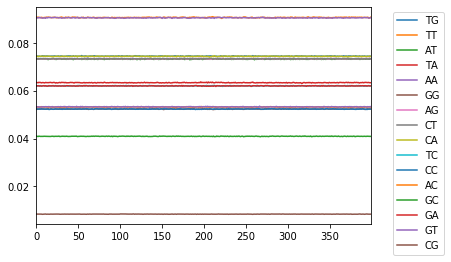

In [22]:
rows_scrnd = 10587902
difreq_df = dimer_df.apply(lambda x: x/rows_scrnd)

difreq_df.plot()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

A list of nucleosomecore sequences is created to compute a position-weight-matrix for a 'nucleosomecore motif'.
Due to hardware limitations, only the nucleosomecores for chromosome 2,3, and 4 are used (chromosome 1 was not used due to reasons mentioned above).

In [2]:
baselen = 200

instances =[]

for i in range(1,4):
    print('opening chromosome', str(i+1))
    csvname = ''.join(["D:\Winter 2021\BIMM 143\Mus_nucleosomecore_", str(i+1), ".txt"])
    chunks = pd.read_csv(csvname, chunksize = 100000, index_col=None, names=['chr', 'ncp', 'nucleosomecore'])

    for chunk in chunks:
        length_check = chunk[chunk['nucleosomecore'].apply(lambda x: len(x) != baselen*2+1)].index
        N_check = chunk[chunk['nucleosomecore'].apply(lambda x: 'N' in x)].index
        droplist = list(set(length_check) | set(N_check))
        chunk.drop(droplist, inplace=True)
        print('rows discarded:', str(len(droplist)))
        sequences = chunk['nucleosomecore'].apply(lambda x: Seq(x))
        instances = instances+(list(sequences))

opening chromosome 2
rows discarded: 222
rows discarded: 0
rows discarded: 0
rows discarded: 0
rows discarded: 0
rows discarded: 0
rows discarded: 0
rows discarded: 856
opening chromosome 3
rows discarded: 357
rows discarded: 0
rows discarded: 1
rows discarded: 5
rows discarded: 114
rows discarded: 0
rows discarded: 0
opening chromosome 4
rows discarded: 193
rows discarded: 69
rows discarded: 480
rows discarded: 9
rows discarded: 0
rows discarded: 1805
rows discarded: 0


A position-weight-matrix is produced for subset of nucleosomecores analyzed.
The pseudocounts used by the biopython function is a dictionary of mouse genome GC content.

The postion-weight-matrix is plotted. Note that the y axis does not start from 0.

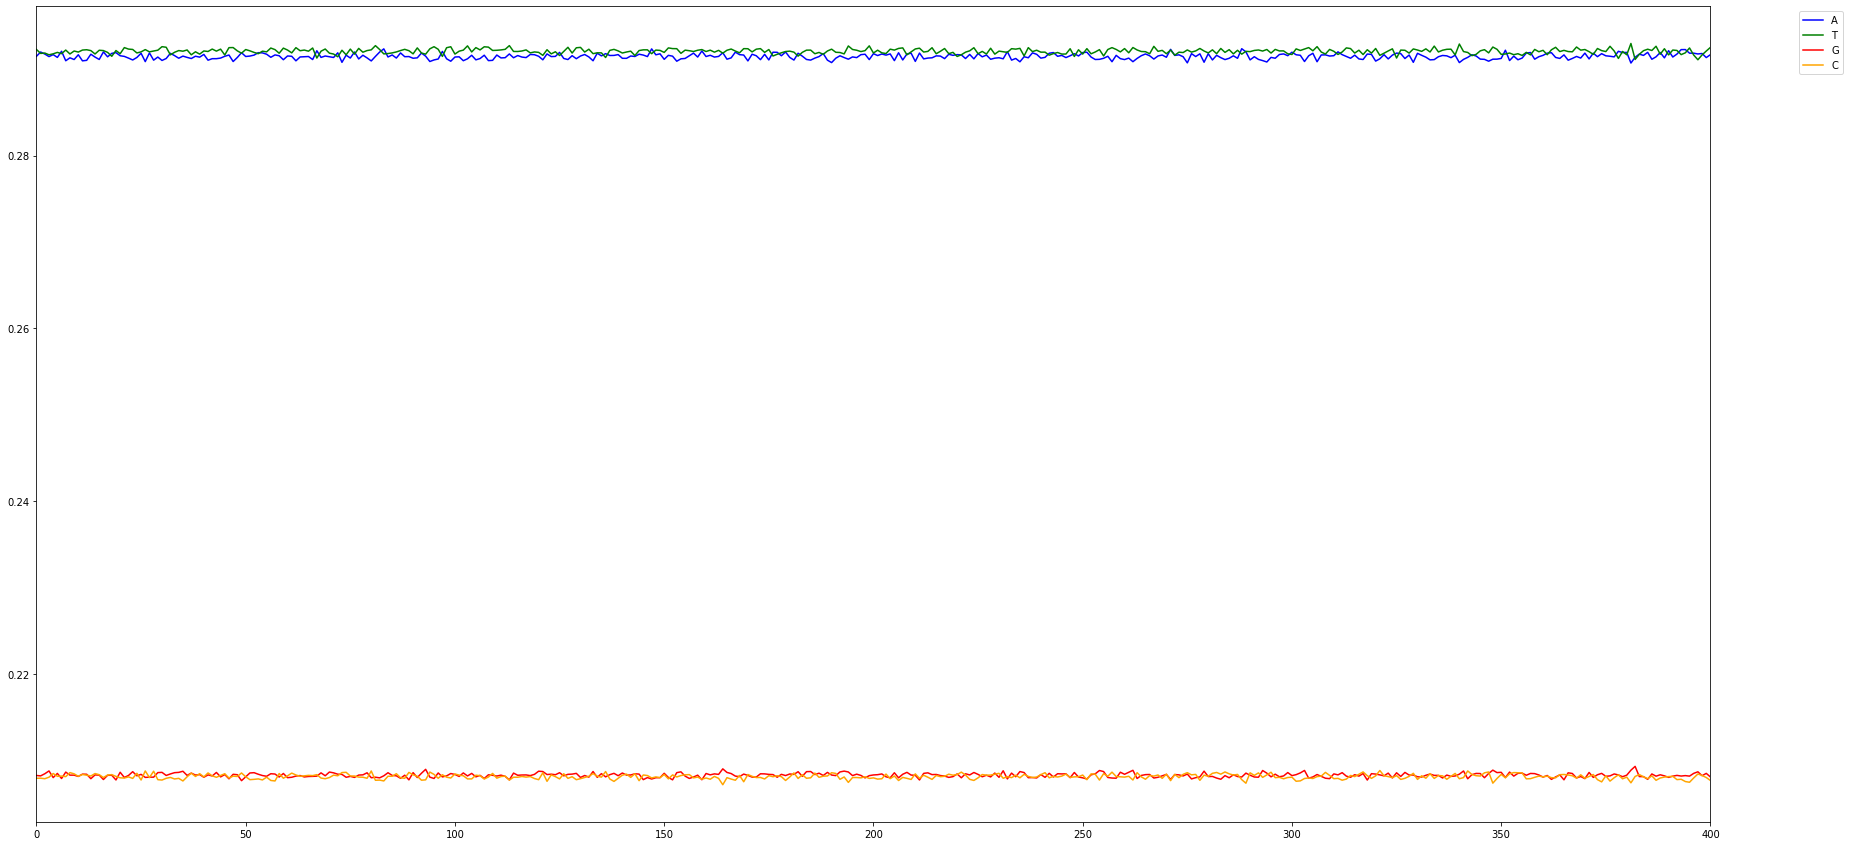

In [3]:
m = motifs.create(instances)
Mus_pseudo={'A':0.58, 'T':0.58,'G':0.42, 'C':0.42}
pwm = m.counts.normalize(pseudocounts=Mus_pseudo)
pwm_df = pd.DataFrame(pwm)
pwm_df[['A','T','G','C']].plot(figsize = (30, 15), color=['blue', 'green', 'red', 'orange'])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

The overall result is extremely monotone, which is surprising because nucleosomes are known to have sequence preferences up to some degree. If there were more time, I would like to re-analyze the nucleosome center position data with the corresponding genome build (mm10 instead of mm39) used by the authors at the time of publication.